In [4450]:
import numpy as np
import pandas as pd
import openpyxl
import time
import matplotlib.pyplot as plt
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.display import Latex, Image
from statsmodels.iolib.summary2 import summary_col
import imageio
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Ellipse

# Welcome!

### Created by Luca Voichick, 4-24-2022

#### Check out the readme to learn more about this project


### Run this next line only if you have time and computer memory to spare
##### Imports all NEUZU data and concats them to a single dataframe

In [2]:
assert False, "Wait! Comment this out only if you have time and computer memory to spare. Otherwise just import the csv file on the next line"

start_time= time.time()
print(round(time.time()-start_time,2))
Dataframe_data2016 = pd.read_excel('data/NEUZU-2016.xlsx', engine='openpyxl')
print(round(time.time()-start_time,2))
Dataframe_data2017 = pd.read_excel('data/NEUZU-2017.xlsx', engine='openpyxl')
print(round(time.time()-start_time,2))
Dataframe_data2018 = pd.read_excel('data/NEUZU-2018.xlsx', engine='openpyxl')
print(round(time.time()-start_time,2))
Dataframe_data2019 = pd.read_excel('data/NEUZU-2019.xlsx', engine='openpyxl')
print(round(time.time()-start_time,2))
Dataframe_data2020 = pd.read_excel('data/NEUZU-2020 delfirstline.xlsx', engine='openpyxl')
print(round(time.time()-start_time,2))
Dataframe_data2021 = pd.read_excel('data/NEUZU-2021 delfirstline.xlsx', engine='openpyxl')
print(round(time.time()-start_time,2))

#combining all data into a dataframe and saving as a .csv file
allNEUZU_together = pd.concat([Dataframe_data2016,Dataframe_data2017,Dataframe_data2018, Dataframe_data2019,Dataframe_data2020,Dataframe_data2021])
allNEUZU_together.to_csv('allNEUZUData.csv')
print(round(time.time()-start_time,2))

0.0
279.48
559.35
827.53
1105.58
1306.96
1513.61
1561.32


## Imports all NEUZU data

In [3]:
allNEUZU_together = pd.read_csv('allNEUZUData.csv', low_memory = False)
print("Imported entire NEUZU dataset, len: ", len(allNEUZU_together))

Imported entire NEUZU dataset, len:  2425320


## Filter the NEUZU dataset, add a quarter term


In [4]:
## removing car class =! 1, 2, 10 ##
carClassFilter = allNEUZU_together['Fahrzeugart_Code'].isin([1,2,10])
filteredNEUZU = allNEUZU_together[carClassFilter] 

## removing those registered in unknown cantons ##
filteredNEUZU = filteredNEUZU[filteredNEUZU['Staat'] == 'Schweiz']

## removing the dozen anomalies with 1 seats or more than 9
filteredNEUZU = filteredNEUZU[~((filteredNEUZU['SitzplÃ¤tze'] <= 1.0) | (filteredNEUZU['SitzplÃ¤tze'] >= 40.0))]

## removing missing datapoints
filteredNEUZU = filteredNEUZU.dropna(subset=['Erstinverkehrsetzung_Monat','Inverkehrsetzung_Kanton','Erstinverkehrsetzung_Jahr','Treibstoff', 'Treibstoff_Code'])

## removing datapoints with mislabelled canton registration ##
cantons_abbr = ['AG', 'AR', 'AI', 'BL', 'BS', 'BE', 'FR', 'GE', 'GL', 'GR', 'JU', 'LU', 'NE', 'NW', 'OW', 'SH', 'SZ', 'SO', 'SG', 'TG', 'TI', 'UR', 'VS', 'VD', 'ZG', 'ZH']
filteredNEUZU = filteredNEUZU[filteredNEUZU['Inverkehrsetzung_Kanton'].isin(cantons_abbr)]
print("Removed", "{:,}".format(len(allNEUZU_together) - len(filteredNEUZU)), "unwanted data points.", "{:,}".format(len(filteredNEUZU)), "remain")

Removed 692,600 unwanted data points. 1,732,720 remain


In [5]:
## Appending a quarter term ##
conditions = [
    (filteredNEUZU['Erstinverkehrsetzung_Monat'] <= 3),
    (filteredNEUZU['Erstinverkehrsetzung_Monat'] >= 4) & (filteredNEUZU['Erstinverkehrsetzung_Monat'] <= 6),
    (filteredNEUZU['Erstinverkehrsetzung_Monat'] >= 7) & (filteredNEUZU['Erstinverkehrsetzung_Monat'] <= 9),
    (filteredNEUZU['Erstinverkehrsetzung_Monat'] >= 10)
]
quarters = [1,2,3,4]

filteredNEUZU['Quarter'] = np.select(conditions, quarters)
filteredNEUZU['YearQuarter'] = filteredNEUZU['Erstinverkehrsetzung_Jahr'].astype(str)+'-'+filteredNEUZU['Quarter'].astype(str)
filteredNEUZU['YearQuarterCanton'] = filteredNEUZU['YearQuarter'].astype(str) + '-' + filteredNEUZU['Inverkehrsetzung_Kanton']

In [6]:
#separating by electric and non-electric
electricFilter = (filteredNEUZU['Treibstoff_Code'] == 'E') | (filteredNEUZU['Treibstoff_Code'] == 'X') | ((filteredNEUZU['Treibstoff_Code'] == 'R') & (filteredNEUZU['Hubraum'] == 0)) 

#creating two datasets - electric vs. non-electric
NEUZU_electric = filteredNEUZU[electricFilter]
NEUZU_nonEV    = filteredNEUZU[~electricFilter]

print("of the", "{:,}".format(len(NEUZU_nonEV) + len(NEUZU_electric)), "registrations between 2016-2021, ","{:,}".format(len(NEUZU_nonEV)),
      "are not fully electric vehicles and", "{:,}".format(len(NEUZU_electric)),"are fully electric")

of the 1,732,720 registrations between 2016-2021,  1,654,831 are not fully electric vehicles and 77,889 are fully electric


## Organizing data by canton, registration quarter-year, eletric vehicle, EV Ratio
#### Horizontal and Vertical Organization

In [9]:
#Breaks up electric and non-electric registrations by canton and returns them as a dataframe
def EV_NonEv_AllRegistrations_Ratio(canton):

    NotEVsNEUZU_byQuarterCanton = NEUZU_nonEV[NEUZU_nonEV['Inverkehrsetzung_Kanton'].isin(canton)]['YearQuarter'
        ].value_counts().reindex(NEUZU_nonEV.YearQuarter.unique(), fill_value=0).sort_index(ascending=True).to_frame()
    
    EVsNEUZU_byQuarterCanton    = NEUZU_electric[NEUZU_electric['Inverkehrsetzung_Kanton'].isin(canton)]['YearQuarter'
        ].value_counts().reindex(NEUZU_electric.YearQuarter.unique(), fill_value=0).sort_index(ascending=True).to_frame()

    if len(canton) > 1: 
        canton = 'All'
    else:
        canton = "_"+ str(canton).replace("[","").replace("]","").replace("'","")
    
    YQRegistrations = pd.concat([EVsNEUZU_byQuarterCanton,NotEVsNEUZU_byQuarterCanton], axis = 1)
    YQRegistrations.columns = ['EVs' + canton, 'NonEVs'+canton]
    
    #calculating total number of vehicles, electric vehicle ratio
    YQRegistrations['AllVehicles'+canton] = YQRegistrations['EVs' + canton] + YQRegistrations['NonEVs'+canton]
    YQRegistrations['EVRatio'+canton] = YQRegistrations['EVs' + canton] / ( YQRegistrations['AllVehicles'+canton] ) *100
    return YQRegistrations

In [10]:
#Concat all cantons horizontally to make it easy to graph by canton
YQRegistrations = pd.DataFrame([])
cantonsInList = [['AG'], ['AR'], ['AI'], ['BL'], ['BS'], ['BE'], ['FR'], ['GE'], ['GL'], ['GR'], ['JU'], ['LU'], ['NE'],
                 ['NW'], ['OW'], ['SH'], ['SZ'], ['SO'], ['SG'], ['TG'], ['TI'], ['UR'], ['VS'], ['VD'], ['ZG'], ['ZH']]

#calculates EV, nonEV, all, and Ratio for all cantons
for canton in cantonsInList:
    YQRegistrations = pd.concat([YQRegistrations,EV_NonEv_AllRegistrations_Ratio(canton)], axis = 1) 

YQRegistrations = pd.concat([YQRegistrations,EV_NonEv_AllRegistrations_Ratio(cantons_abbr)], axis = 1).reset_index().rename(columns={"index": "YearQuarter"})



## Testing Graphs
For any cantons listed above, type the following options into the list:
 - EVRatio_'canton-abbreviation'
 - AllVehicles_'canton-abbreviation'
 - NonEVs_'canton-abbreviation'
 - Replace the '_canton-abbreviation' with 'All' to see across all cantons

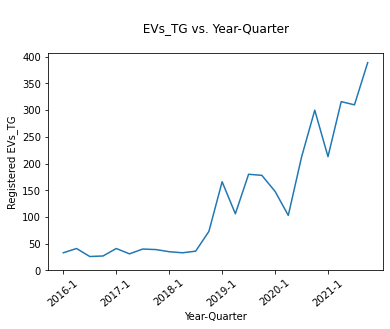

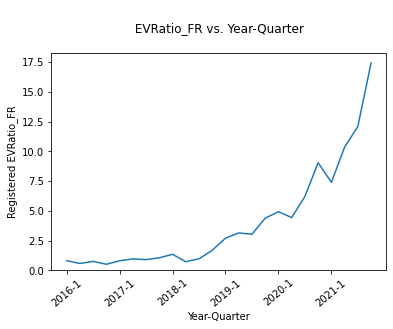

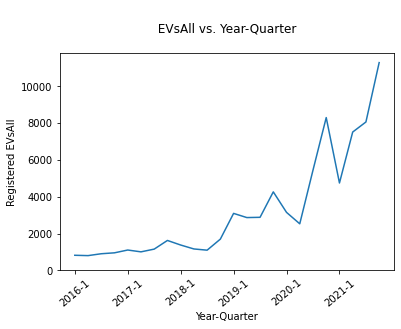

In [11]:
#print(YQRegistrations[['EVRatio_TG', 'YearQuarter']])

#example:
for y_input in ['EVs_TG','EVRatio_FR', 'EVsAll']:
    xs = YQRegistrations['YearQuarter']
    plt.plot(xs, YQRegistrations[y_input])
    plt.xticks(np.arange(0, 24, 4), rotation = 40)
    plt.xlabel("Year-Quarter", fontsize = 10)
    plt.ylabel(f"Registered {y_input}", fontsize = 10)
    plt.title(f"\n {y_input} vs. Year-Quarter \n", fontsize = 12)
    plt.ylim(bottom = 0)
    plt.show()

In [12]:
### Organizes vertically to make regressions easier ###

Regression_CYQ = pd.DataFrame([])
mergedDf = pd.DataFrame([])

cantonsInList = [['AG'], ['AR'], ['AI'], ['BL'], ['BS'], ['BE'], ['FR'], ['GE'], ['GL'], ['GR'], ['JU'], ['LU'], ['NE'], ['NW'], ['OW'], ['SH'], ['SZ'], ['SO'], ['SG'], ['TG'], ['TI'], ['UR'], ['VS'], ['VD'], ['ZG'], ['ZH']]

for canton in cantonsInList:
    temp = pd.DataFrame([])
    cantonString = str(canton).replace("[","").replace("]","").replace("'","")
    #print(cantonString)
    CantonVals = EV_NonEv_AllRegistrations_Ratio(canton)
    CantonVals['CantonName'] = cantonString
    temp = pd.concat([temp,CantonVals], axis = 0).reset_index().rename(columns={"index": "YearQuarter", "EVs_" + cantonString: "EVs","NonEVs_" + cantonString: "NonEVs","AllVehicles_" + cantonString: "AllVehicles","EVRatio_" + cantonString: "EVRatio"})
    Regression_CYQ = pd.concat([Regression_CYQ, temp], ignore_index = True)

Regression_CYQ['CantonYearQuarter'] = Regression_CYQ['CantonName'].astype(str) + Regression_CYQ['YearQuarter'].astype(str)
Regression_CYQ['CantonYear'] = Regression_CYQ['CantonName'].astype(str) +"-"+ Regression_CYQ['YearQuarter'].str[0:4]

Regression_CYQ['Quarter'] = Regression_CYQ['YearQuarter'].str[5].astype(int)
Regression_CYQ['Year'] =    Regression_CYQ['YearQuarter'].str[0:4].astype(int)



## Appending regressors (purchase premiums, charging subsidies, tax ratio, population density)

In [13]:
## Appending a purchase premium term ##
purchasePremium = [
    (Regression_CYQ['CantonName'] == 'TG') & (Regression_CYQ['Year'] >= 2021),
    (Regression_CYQ['CantonName'] == 'TG') & (Regression_CYQ['Year'] == 2020),
    (Regression_CYQ['CantonName'] == 'TG') & (Regression_CYQ['Year'] == 2019),
    
    (Regression_CYQ['CantonName'] == 'TI') & ((Regression_CYQ['Year'] >= 2020) | ((Regression_CYQ['Year'] >= 2019) & (Regression_CYQ['Quarter'] >= 3))),
    
    (Regression_CYQ['CantonName'] == 'VS') & ((Regression_CYQ['Year'] == 2021) | ((Regression_CYQ['Year'] >= 2020) & (Regression_CYQ['Quarter'] == 4))),

    (Regression_CYQ['CantonName'] == 'SH') & ((Regression_CYQ['Year'] >= 2021))
]

premium_1000 = [2.0,3.5,4.0,  2,   3.5,   2]

Regression_CYQ['PP_1000'] = np.select(purchasePremium, premium_1000)
Regression_CYQ['PP_1000'] = np.where(Regression_CYQ['PP_1000'] > 0, Regression_CYQ['PP_1000'], 0)

#print(Regression_CYQ[Regression_CYQ['PP_1000'] != 0.0][['PP_1000','YearQuarter','CantonName']])  

Info on premiums:

**Thurgau** offers 4000 CHF in 2019 [Thurgau - 2019](https://akuratleag.ch/userdata/pdf/foerderprogramm-tg-2019-v1-0.pdf)   
In 2020, decrease offer to 3500 CHF [Thurgau - 2020](https://energie.tg.ch/public/upload/assets/92935/Foerderprogramm_TG_2020_V1-0.pdf)                     
In 2021, decrease to 2000 CHF [Thurgau - 2021](https://energie.tg.ch/public/upload/assets/114388/F%C3%B6rderprogramm_TG_2021_V1-2.pdf)

**Ticino** gets subsidy of 2000 CHF starting July 1, 2019 [Ticino - 2019](https://www4.ti.ch/index.php?id=34457)

**Valais** Nov 1 2020 to end of 2022, subsidy of 3500 CHF [Valais - 2020](https://auto-hermann.ch/elektro-competence/foerderbeitraege/)

**Schaffhausen** 2000 CHF starting Jan 2021 [Schaffhausen - 2021](https://sh.ch/CMS/Webseite/Kanton-Schaffhausen/Beh-rde/Verwaltung/Baudepartement-7314556-DE.html)

In [14]:
## Appending a charging station subsidy term ##
csSubsidy = [
    (Regression_CYQ['CantonName'] == 'GE') &  (Regression_CYQ['Year'] >= 2019),
    
    (Regression_CYQ['CantonName'] == 'TI') & ((Regression_CYQ['Year'] >= 2020) | ((Regression_CYQ['Year'] >= 2019) & (Regression_CYQ['Quarter'] >= 3))),
    
    (Regression_CYQ['CantonName'] == 'VS') & ((Regression_CYQ['Year'] == 2021) | ((Regression_CYQ['Year'] >= 2020) & (Regression_CYQ['Quarter'] == 4))),

    (Regression_CYQ['CantonName'] == 'VD') &  (Regression_CYQ['Year'] >= 2021),

]

cs_1000 = [1.0, 0.5, 1.5  , 2.0]

Regression_CYQ['CS_1000'] = np.select(csSubsidy, cs_1000)
Regression_CYQ['CS_1000'] = np.where(Regression_CYQ['CS_1000'] > 0, Regression_CYQ['CS_1000'], 0) 

#print(Regression_CYQ[Regression_CYQ['CS_1000'] != 0.0][['CS_1000','YearQuarter','CantonName']])

Info on charging station subsidies: [More info](https://auto-hermann.ch/elektro-competence/foerderbeitraege/)

**Geneva** 2000 CHF starting Jan 1 2029 [Geneva - 2019](https://www.ge.ch/subventions-borne-electromobilite) 

**Ticino** 500 CHF starting June 19, 2019. Ran out by end of 21 [Ticino - 2019](https://www4.ti.ch/index.php?id=34457) 

**Valais** 1500 CHF starting Nov 1 2020 [Valais - 2019](https://web.archive.org/web/20210302174545/https:/www.vs.ch/de/web/agenda2030_theme/la-directive) for a single 11-22 kW charging station  

**Vaud** 2000 CHF Released on Dec 2020 [Vaud - 2019](https://www.vd.ch/prestation-detail/prestation/26-demander-une-subvention-pour-linfrastructure-de-recharge-de-la-mobilite-individuelle-electrique/)



## Appending Vehicle Price Ratio and Social Controls (Tertiary and Pop Density)

In [15]:
## Appending Social Controls (PopDensity, Vehicle Prices)
CPDY = pd.read_excel('data/PopulationOver25AndTertiary.xlsx', engine='openpyxl')
CYQ_preDummies = pd.merge(left=Regression_CYQ, right=CPDY, left_on='CantonYear', right_on='Canton-Year').rename(columns={"Year_x": "Year"})

CYQ_preDummies['Pct Tertiary']       = CYQ_preDummies['Pct_Tertiary'] * 100
CYQ_preDummies['PopDen(Over25)_log'] = np.log(CYQ_preDummies['Population_Density_Over25'])

## Filtering CO2 outliers for calculating CO2 mean regressand

In [16]:
#Note: by removing CO2 emissions anomalies, I would need to assume that the anomalies are randomly distributed among 
#the dataset as I am still counting these vehicles in the number of registrations. This is unfortunately incorrect,
#as hybrids and certain brands appeared to be statistically more likely to be missing datapoints. Regarless, very 
#few vechiles are removed relative to the larger sample size so this impact is likely minimal

### calculating CO2 averages by quarter, year, canton. ###
filteredNEUZU['RealTreibstoff_Code'] = filteredNEUZU['Treibstoff_Code']

## Appending CO2 Mean
print("Original dataset length: ",  "{:,}".format(len(filteredNEUZU)),"\n")

print("Filtering out values without energy category: ", len(filteredNEUZU) - len(filteredNEUZU[filteredNEUZU['RealTreibstoff_Code'].notna()]))
CO2Filtered = filteredNEUZU[filteredNEUZU['RealTreibstoff_Code'].notna()]

print("Removing non-electric vehicles listed as having incorrectly low carbon emissions: ",  len(CO2Filtered[((~CO2Filtered['RealTreibstoff_Code'].isin(['E','R','X'])) & (CO2Filtered['CO2'] <= 25))]))
CO2Filtered = (CO2Filtered[~((~CO2Filtered['RealTreibstoff_Code'].isin(['E','R','X'])) & (CO2Filtered['CO2'] <= 25))])

print("Replacing REX models with an engine as non-EVs: ", len(CO2Filtered[(CO2Filtered['RealTreibstoff_Code'] == 'R') & (CO2Filtered['Hubraum'] > 0)])  )
CO2Filtered['RealTreibstoff_Code'] = np.where((CO2Filtered['RealTreibstoff_Code'] == 'R') & (CO2Filtered['Hubraum'] > 0), 'REX-WithEngine', CO2Filtered['RealTreibstoff_Code'])

print ("Setting CO2 emissions for EVs to zero: ", len( (CO2Filtered[((CO2Filtered['RealTreibstoff_Code'].isin(['E','R','X'])) & (CO2Filtered['CO2'] > 10)) ] )) )
CO2Filtered['CO2'] = np.where(CO2Filtered['RealTreibstoff_Code'].isin(['E','R','X']), 0, CO2Filtered['CO2'])

print("Filtering out values without CO2 emissions: ",  "{:,}".format((len(CO2Filtered) - len(CO2Filtered[CO2Filtered['CO2'] >= 0])))) 
CO2Filtered = CO2Filtered[CO2Filtered['CO2'].notna()]

print("Filtering out incorrectly high CO2 emissions data: ", len(CO2Filtered[(CO2Filtered['CO2'] > 500)]))
CO2Filtered = CO2Filtered[(CO2Filtered['CO2'] <= 500)]

print("\nCleaned CO2 data length:",  "{:,}".format(len(CO2Filtered)), "  which is a", round((len(filteredNEUZU) - len(CO2Filtered))/len(filteredNEUZU)*100,3), "percent decrease in size" )

Original dataset length:  1,732,720 

Filtering out values without energy category:  0
Removing non-electric vehicles listed as having incorrectly low carbon emissions:  199
Replacing REX models with an engine as non-EVs:  156
Setting CO2 emissions for EVs to zero:  770
Filtering out values without CO2 emissions:  89,833
Filtering out incorrectly high CO2 emissions data:  174

Cleaned CO2 data length: 1,642,514   which is a 5.206 percent decrease in size


## Merging CO2 data with Regression Dataset

In [17]:
#Organizing CO2 emissions by canton year, quarter and merging with CO2 dataset

CO2Filtered['Year-Quarter'] = CO2Filtered['YearQuarter']

Co2Avg = CO2Filtered.groupby(['Inverkehrsetzung_Kanton','Year-Quarter']).CO2.agg(['mean', 'median', 'min', 'max', 'count']).reset_index().rename(columns={'mean':'CO2Mean', 'median':'CO2Median'})
Co2AvgAll = CO2Filtered.groupby(['Year-Quarter']).CO2.agg(['mean', 'median', 'min', 'max', 'count']).reset_index().rename(columns={'mean':'CO2Mean', 'median':'CO2Median'})

Co2Avg['CantonYearQuarter'] = Co2Avg['Inverkehrsetzung_Kanton'].astype(str) + Co2Avg['Year-Quarter'].astype(str)
CYQ_preDummies_CO2 = pd.merge(left=CYQ_preDummies, right=Co2Avg, left_on='CantonYearQuarter', right_on='CantonYearQuarter').rename(columns={'CantonName':'Canton'})

## Taking natural log of regressands
#### Note - this cell will run an error due to taking the natural log of 0s. These terms will be removed in the regressions

In [18]:
CYQ_preDummies_CO2['EVs_log']          = np.log(CYQ_preDummies_CO2['EVs'])
CYQ_preDummies_CO2['MkShr(100)_log']   = np.log(CYQ_preDummies_CO2['EVRatio'])
CYQ_preDummies_CO2['AllVehicles_log']  = np.log(CYQ_preDummies_CO2['AllVehicles'])
CYQ_preDummies_CO2['CO2Mean_log']      = np.log(CYQ_preDummies_CO2['CO2Mean'])

#removing natural logs of 0 in the regressions
CYQ_preDummies_CO2 = CYQ_preDummies_CO2.replace([np.inf, -np.inf], np.nan)

/home/DAVIDSON/luvoichick/.local/share/virtualenvs/test_dir-qAlmLPul/lib64/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Summary Statistic tables, latex form

In [19]:
regressands = ['EVs','EVRatio', 'AllVehicles', 'CO2Mean']
regressands_log = ['EVs_log','MkShr(100)_log', 'AllVehicles_log', 'CO2Mean_log']
taxratio = ['TaxRatio']
socials = ['Pct Tertiary', 'Population_Density_Over25', 'PopulationOver25']

#latex commented out below
for tables in [regressands, regressands_log, taxratio, socials]:
    print(CYQ_preDummies_CO2[tables].describe().round(2))
    #print(CYQ_preDummies_CO2[tables].describe().round(2).to_latex().replace("mean","Mean").replace("count","Count").replace("std","St. Dev.").replace("min","Min").replace("max","Max").replace("624.00", "624").replace("622.00","622"))

           EVs  EVRatio  AllVehicles  CO2Mean
count   624.00   624.00       624.00   624.00
mean    124.82     4.77      2776.79   130.82
std     222.57     4.93      2753.87    14.17
min       0.00     0.00       176.00    73.17
25%      19.00     1.22       655.25   128.94
50%      47.00     2.60      1939.50   134.18
75%     133.00     6.68      3649.50   139.07
max    2305.00    24.07     14052.00   153.22
       EVs_log  MkShr(100)_log  AllVehicles_log  CO2Mean_log
count   622.00          622.00           624.00       624.00
mean      3.84            1.02             7.42         4.87
std       1.49            1.12             1.08         0.12
min       0.00           -3.58             5.17         4.29
25%       2.94            0.20             6.48         4.86
50%       3.85            0.97             7.57         4.90
75%       4.89            1.90             8.20         4.94
max       7.74            3.18             9.55         5.03
       TaxRatio
count    624.00
mean 

## Converting dummy variables and saving aggregated dataset to .csv file

In [20]:
CYQ_dummies = pd.get_dummies(CYQ_preDummies_CO2, columns = ['YearQuarter'])
CYQ_dummies = pd.get_dummies(CYQ_dummies, columns = ['Canton'])

CYQ_dummies.to_csv('CYQ_dummies.csv')

In [21]:
CYQ_dummies['PopulationOver25_log'] = np.log(CYQ_dummies['PopulationOver25'])

In [22]:
CYQ_dummies['Year-Quarter'] = CYQ_preDummies_CO2['YearQuarter']

# Regression set-up

In [2422]:
#lists for controls
priceControls =  ['CS_1000','TaxRatio']
socialControls = ['Pct Tertiary', 'PopDen(Over25)_log']
cantonControls = ["Canton_AG","Canton_AI","Canton_AR","Canton_BE","Canton_BL",
                  "Canton_BS","Canton_FR","Canton_GE","Canton_GL","Canton_GR",
                  "Canton_JU","Canton_LU","Canton_NE","Canton_NW","Canton_OW",
                  "Canton_SG","Canton_SH","Canton_SO","Canton_SZ","Canton_TG",
                  "Canton_TI","Canton_UR","Canton_VD","Canton_VS","Canton_ZG"]  #" Canton_ZH #dummy variable trap!
yearControls =   ["YearQuarter_2016-2","YearQuarter_2016-3","YearQuarter_2016-4",
                  "YearQuarter_2017-1","YearQuarter_2017-2","YearQuarter_2017-3","YearQuarter_2017-4",
                  "YearQuarter_2018-1","YearQuarter_2018-2","YearQuarter_2018-3","YearQuarter_2018-4",
                  "YearQuarter_2019-1","YearQuarter_2019-2","YearQuarter_2019-3","YearQuarter_2019-4",
                  "YearQuarter_2020-1","YearQuarter_2020-2","YearQuarter_2020-3","YearQuarter_2020-4",
                  "YearQuarter_2021-1","YearQuarter_2021-2","YearQuarter_2021-3","YearQuarter_2021-4"] #"YearQuarter_2016-1", #dummy variable trap!

#building the lists of the models
model1Regressors = ['PP_1000']
model2Regressors = ['PP_1000'] + priceControls
model3Regressors = ['PP_1000'] + priceControls + socialControls
model4Regressors = ['PP_1000'] + priceControls + socialControls + cantonControls
model5Regressors = ['PP_1000'] + priceControls + socialControls + yearControls
model6Regressors = ['PP_1000'] + priceControls + socialControls + cantonControls + yearControls

#attributing the values from the CYQ dataset (with dummy variables)
X_1 = CYQ_dummies[model1Regressors ]
X_2 = CYQ_dummies[model2Regressors ]
X_3 = CYQ_dummies[model3Regressors ]
X_4 = CYQ_dummies[model4Regressors ]
X_5 = CYQ_dummies[model5Regressors ]
X_6 = CYQ_dummies[model6Regressors ]


In [2423]:
#this function takes a regressand input and returns a dataframe with regression information
def runRegression(regressand):
    Y = CYQ_dummies[regressand]
    
    ## clustered at canton level ##
    c_id = CYQ_dummies.dropna(subset = [regressand])['FrenchCantonName'] 
    
    #adding a constant term, dropping NaN ln(0) explained variables, clustering at canton level due to expected 
    #herteroskidasticity resulting from increase in variance with time) and using robust standard errros
    model1 = sm.OLS(Y, sm.add_constant(X_1), missing = 'drop').fit(cov_type='cluster', cov_kwds={'groups': c_id})
    model2 = sm.OLS(Y, sm.add_constant(X_2), missing = 'drop').fit(cov_type='cluster', cov_kwds={'groups': c_id})
    model3 = sm.OLS(Y, sm.add_constant(X_3), missing = 'drop').fit(cov_type='cluster', cov_kwds={'groups': c_id})
    model4 = sm.OLS(Y, sm.add_constant(X_4), missing = 'drop').fit(cov_type='cluster', cov_kwds={'groups': c_id})
    model5 = sm.OLS(Y, sm.add_constant(X_5), missing = 'drop').fit(cov_type='cluster', cov_kwds={'groups': c_id})
    model6 = sm.OLS(Y, sm.add_constant(X_6), missing = 'drop').fit(cov_type='cluster', cov_kwds={'groups': c_id})
    
    
    dfmodels = summary_col([model1, model2,model3,model4,model5,model6],stars=True,
        model_names=['\nPurchase Premiums\n(1)\n','\nVehicle Price Controls\n(2)\n','\n     Social Controls     \n(3)\n','\n         Canton FE        \n(4)\n','\nTime FEs w/out Canton FEs\n(5)\n','\nTime FEs & Canton FEs\n(6)\n'], 
        info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),  #'Number of Xs':lambda x: x.nobs,
            'Time Fe': lambda x: "Model 4 & 6",
            'Canton Fe': lambda x: "Model 5 & 6"},
        float_format='%0.3f', 
        regressor_order=model3Regressors, 
        drop_omitted=True)

    return dfmodels

## Running Regressions
**1) EVs_log** is the natural log of electric vehicle sales by quarter-year-canton

**2) MkShr(100)_log** is the natural log of electric vehicle market share by quarter-year-canton

**3) AllVehicles_log** is the natural log of all vehicle sales by quarter-year-canton

**4) CO2Mean_log** is the natural log of the average CO2 emissions of newly registered vehicles within each quarter-year-canton

In [2424]:
for regressand in regressands_log:
    print(regressand, runRegression(regressand).as_latex().replace('***   ','^{***}').replace('**   ','^{**}').replace('*   ','^{*}').replace("R-squared","Rtextsuperscript{2}").replace("N","Rtextsuperscript{2}"))
    #print(regressand, " ", runRegression(regressand))
    print("\n", "\n", "\n", "\n")

EVs_log \begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllllll}
\hline
                    &                   &                        &                           &                            &                           &                         \\
                    & Purchase Premiums & Vehicle Price Controls &      Social Controls      &          Canton FE         & Time FEs w/out Canton FEs & Time FEs \& Canton FEs  \\
                    & (1)               & (2)                    & (3)                       & (4)                        & (5)                       & (6)                     \\
                    &                   &                        &                           &                            &                           &                         \\
\hline
PP\_1000            & 0.527^{***}       & 0.346^{***}            & 0.493^{***}               & 0.186^{**}                 & 0.285^{***}               & 0.086^{***}             \\
         

# Making some graphs

/home/DAVIDSON/luvoichick/.local/share/virtualenvs/test_dir-qAlmLPul/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


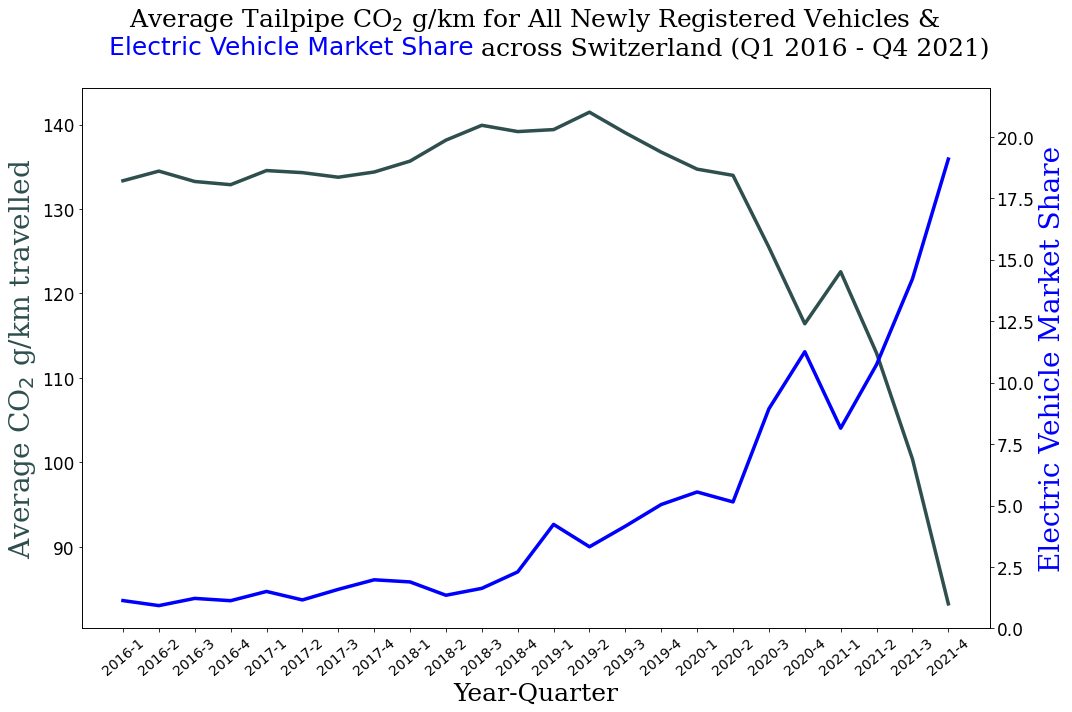

In [2827]:
fonttype = 'serif'

Co2AvgAll = CO2Filtered.groupby(['Year-Quarter']).CO2.agg(['mean', 'median', 'min', 'max', 'count']).reset_index().rename(columns={'index': 'Year-Quarter','mean':'CO2Mean', 'median':'CO2Median'})
fig, ax = plt.subplots(figsize = (15, 10))
ax.set_title('Average Tailpipe CO' + r'$_{2}$' + ' g/km for All Newly Registered Vehicles & \n                                                   across Switzerland (Q1 2016 - Q4 2021) \n', fontsize = 25,  fontname = fonttype)
ax2 = ax.twinx()

ax2.set_title('\nElectric Vehicle Market Share                                                             \n', fontsize = 25, color = 'b')
ax.plot(Co2AvgAll['Year-Quarter'], Co2AvgAll.CO2Mean, color = 'darkslategrey', linewidth=3.5)
ax2.plot(YQRegistrations['YearQuarter'],YQRegistrations.EVRatioAll, color = 'b', linewidth=3.5)
ax2.tick_params(axis='y', labelsize=17)
 
ax.set_xlabel('Year-Quarter', color = 'k', fontsize = 25,  fontname = fonttype)
ax.set_ylabel("Average CO" + r'$_{2}$' + ' g/km travelled', color = 'darkslategrey', fontsize = 28,  fontname = fonttype)
ax.tick_params(axis='y', labelsize=17)
 
ax2.set_ylabel('Electric Vehicle Market Share', color = 'b', fontsize = 28,  fontname = fonttype)
ax2.set_ylim(0,22) 

ax.set_xticklabels(YQRegistrations.YearQuarter,rotation= 40, fontsize = 14)
plt.tight_layout()

print()
print()
plt.savefig("photos/" + "Emissions" + ".png")
plt.show()
print()

In [ ]:
Co2AvgAll = CO2Filtered.groupby(['Year-Quarter']).CO2.agg(['mean', 'median', 'min', 'max', 'count']).reset_index().rename(columns={'index': 'Year-Quarter','mean':'CO2Mean', 'median':'CO2Median'})
fig, ax = plt.subplots(figsize = (15, 9))
ax.set_title('Average Tailpipe CO' + r'$_{2}$' + ' g/km for All Newly Registered Vehicles & \n                                                  across Switzerland (Q1 2016 - Q4 2021) \n', fontsize = 24)
ax2 = ax.twinx()

ax2.set_title('Electric Vehicle Market Share                                                             \n', fontsize = 24, color = 'b')
ax.plot(Co2AvgAll['Year-Quarter'], Co2AvgAll.CO2Mean, color = 'darkslategrey', linewidth=3.0)
ax2.plot(YQRegistrations['YearQuarter'],YQRegistrations.EVRatioAll, color = 'b', linewidth=3.0)
 
ax.set_xlabel('Year-Quarter', color = 'k', fontsize = 21)
ax.set_ylabel("Average CO" + r'$_{2}$' + 'g/km travelled', color = 'darkslategrey', fontsize = 21)
 
ax2.set_ylabel('Electric Vehicle Market Share', color = 'b', fontsize = 21)
ax2.set_ylim(0,22) 

ax.set_xticklabels(YQRegistrations.YearQuarter,rotation= 40, fontsize = 14)
plt.tight_layout()

print()
print()
plt.savefig("photos/" + "Emissions" + ".png")
plt.show()
print()

/home/DAVIDSON/luvoichick/.local/share/virtualenvs/test_dir-qAlmLPul/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


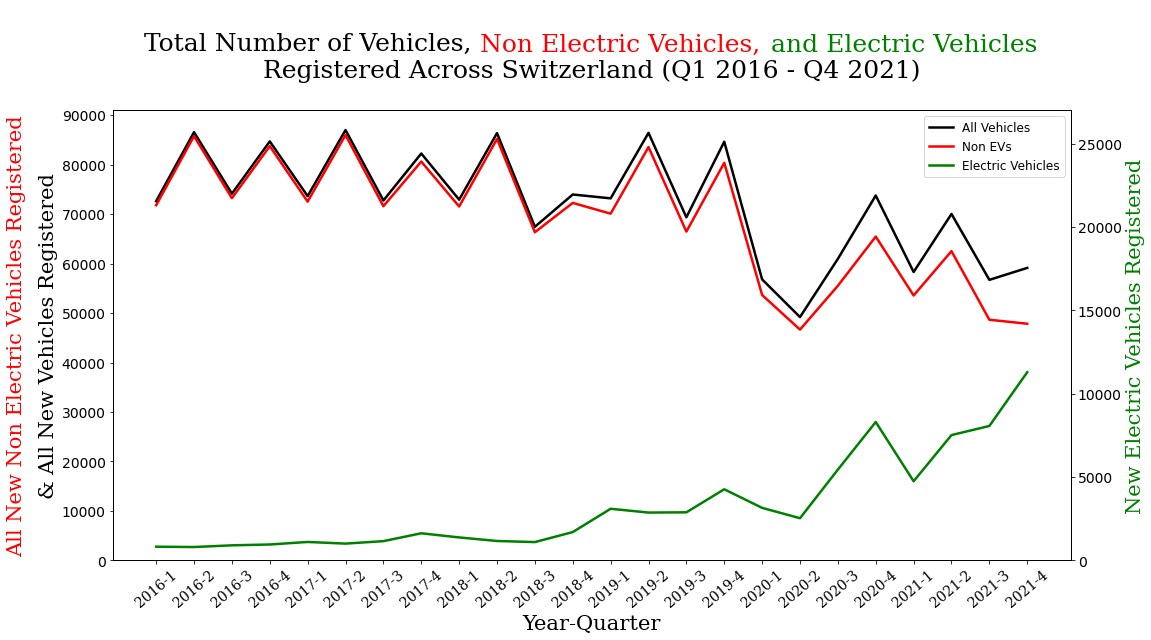

In [2828]:
fonttype = 'serif'




fig, ax = plt.subplots(figsize = (16, 9))
ax.set_title('Total Number of Vehicles,                                                                       \n Registered Across Switzerland (Q1 2016 - Q4 2021) \n',fontsize = 25, fontname = fonttype)
ax2 = ax.twinx()
ax2.set_title('\n        Non Electric Vehicles, \n \n',fontsize = 25, color = 'r', fontname = fonttype)
ax3 = ax.twinx()
ax3.set_title('\n                                                                                and Electric Vehicles  \n \n', fontsize = 25, color = 'g',fontname = fonttype)

EVS = ax3.plot(YQRegistrations.YearQuarter,YQRegistrations.EVsAll, color = 'g' , label = "Electric Vehicles", linewidth = 2.5)
NONEVS = ax2.plot(YQRegistrations.YearQuarter, YQRegistrations.NonEVsAll, color = 'r', label = "Non EVs", linewidth = 2.5)
ALL = ax.plot(YQRegistrations.YearQuarter, YQRegistrations.AllVehiclesAll, color = 'k', label = "All Vehicles", linewidth = 2.5)

lns =   ALL + NONEVS + EVS
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="upper right", fontsize = 12)

ax.set_xlabel('Year-Quarter', color = 'k', fontsize = 21,fontname = fonttype)
ax.set_ylabel('& All New Vehicles Registered', color = 'k',fontsize = 21,fontname = fonttype)
ax.set_xticklabels(YQRegistrations.YearQuarter,rotation= 40, fontsize = 14,fontname = fonttype)
ax.set_yticks(np.arange(0,100000,10000))
ax.set_ylim(0,91000)
ax.tick_params(axis='y', labelsize=14)

ax2.set_ylabel('All New Non Electric Vehicles Registered', color = 'r',fontsize = 21,fontname = fonttype)
ax2.yaxis.set_label_coords(-.11, .5)
ax2.set_yticks([])
ax2.set_ylim(0,91000)
ax2.tick_params(axis='y', labelsize=14)

ax3.set_ylabel('New Electric Vehicles Registered', color = 'g',fontsize = 21,fontname = fonttype)
ax3.set_yticks(np.arange(0,45000,5000))
ax3.set_ylim(0,27000)
ax3.tick_params(axis='y', labelsize=14)

plt.tight_layout()

print()
print()
plt.savefig("photos/" + "All,Non,EV" + ".png")
plt.show()

print()
print()

/home/DAVIDSON/luvoichick/.local/share/virtualenvs/test_dir-qAlmLPul/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


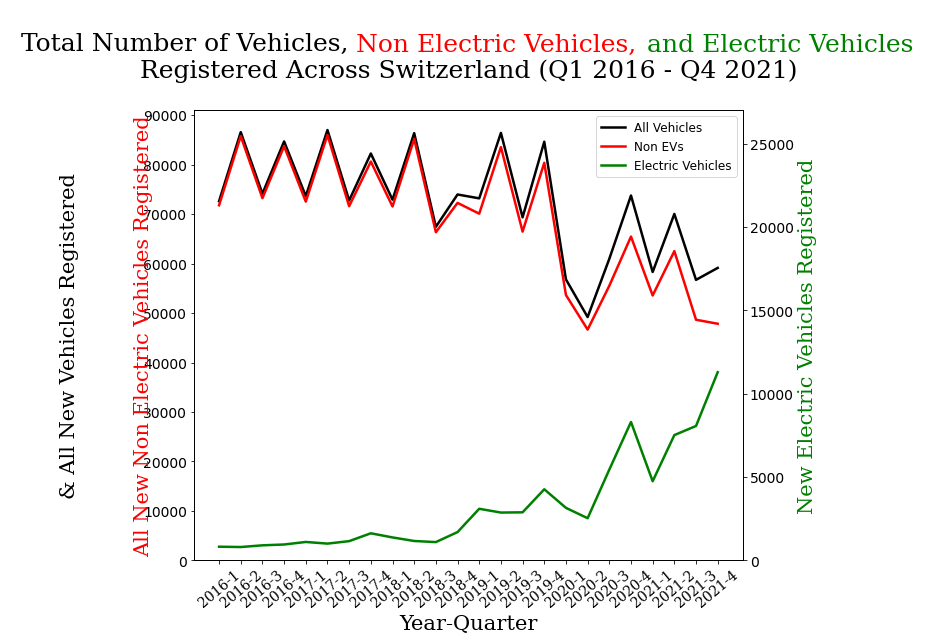

In [2809]:
fonttype = 'serif'

fig, ax = plt.subplots(figsize = (11, 9))
ax.set_title('Total Number of Vehicles,                                                                       \n Registered Across Switzerland (Q1 2016 - Q4 2021) \n',fontsize = 25, fontname = fonttype)
ax2 = ax.twinx()
ax2.set_title('\n        Non Electric Vehicles, \n \n',fontsize = 25, color = 'r', fontname = fonttype)
ax3 = ax.twinx()
ax3.set_title('\n                                                                                and Electric Vehicles  \n \n', fontsize = 25, color = 'g',fontname = fonttype)

EVS = ax3.plot(YQRegistrations.YearQuarter,YQRegistrations.EVsAll, color = 'g' , label = "Electric Vehicles", linewidth = 2.5)
NONEVS = ax2.plot(YQRegistrations.YearQuarter, YQRegistrations.NonEVsAll, color = 'r', label = "Non EVs", linewidth = 2.5)
ALL = ax.plot(YQRegistrations.YearQuarter, YQRegistrations.AllVehiclesAll, color = 'k', label = "All Vehicles", linewidth = 2.5)

lns =   ALL + NONEVS + EVS
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="upper right", fontsize = 12)

ax.set_xlabel('Year-Quarter', color = 'k', fontsize = 21,fontname = fonttype)
ax.set_ylabel('& All New Vehicles Registered', color = 'k',fontsize = 21,fontname = fonttype)
ax.yaxis.set_label_coords(-.21, .5)
ax.set_xticklabels(YQRegistrations.YearQuarter,rotation= 40, fontsize = 14,fontname = fonttype)
ax.set_yticks(np.arange(0,100000,10000))
ax.set_ylim(0,91000)
ax.tick_params(axis='y', labelsize=14)

ax2.set_ylabel('All New Non Electric Vehicles Registered', color = 'r',fontsize = 21,fontname = fonttype)
ax2.yaxis.set_label_coords(-.11, .5)
ax2.set_yticks([])
ax2.set_ylim(0,91000)
ax2.tick_params(axis='y', labelsize=14)

ax3.set_ylabel('New Electric Vehicles Registered', color = 'g',fontsize = 21,fontname = fonttype)
ax3.set_yticks(np.arange(0,45000,5000))
ax3.set_ylim(0,27000)
ax3.tick_params(axis='y', labelsize=14)

plt.tight_layout()

print()
print()
plt.savefig("photos/" + "All,Non,EV" + ".png")
plt.show()

print()
print()

In [2804]:
### plot EV Market Share ###

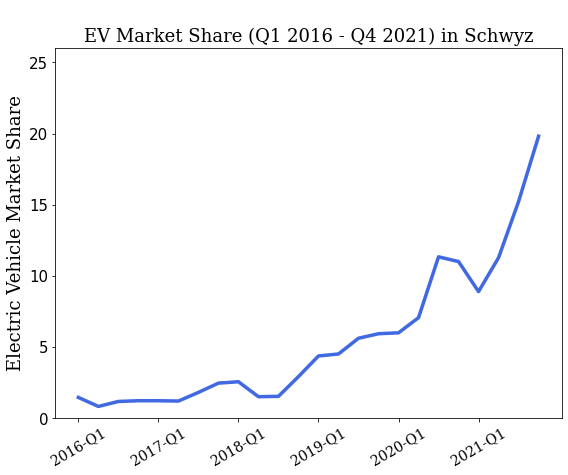

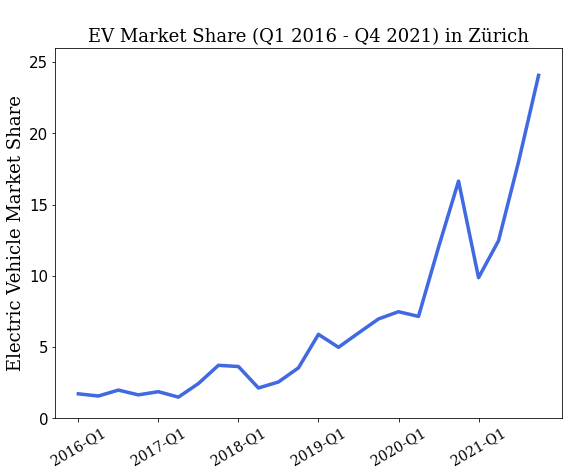

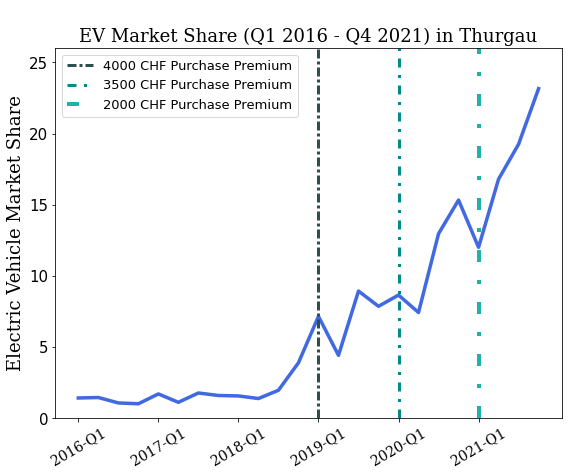

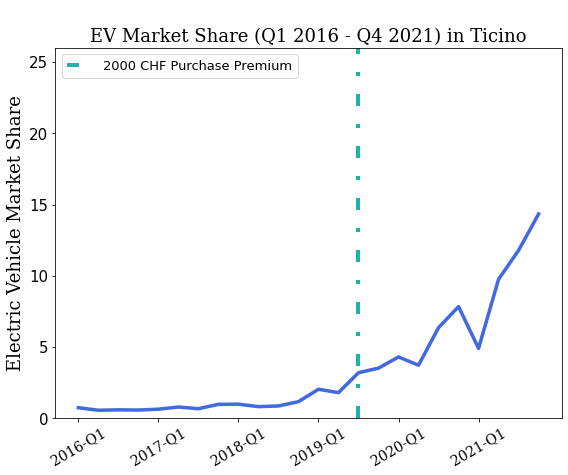

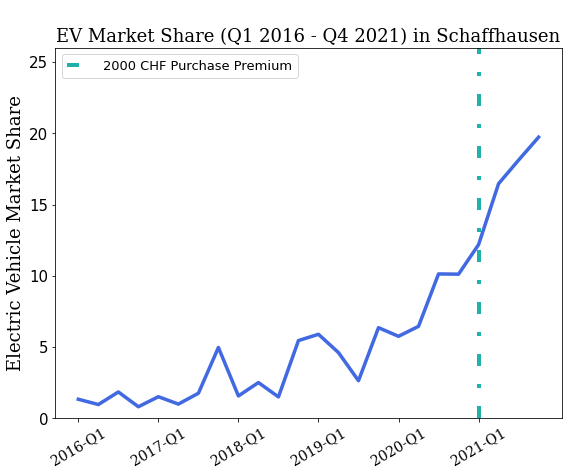

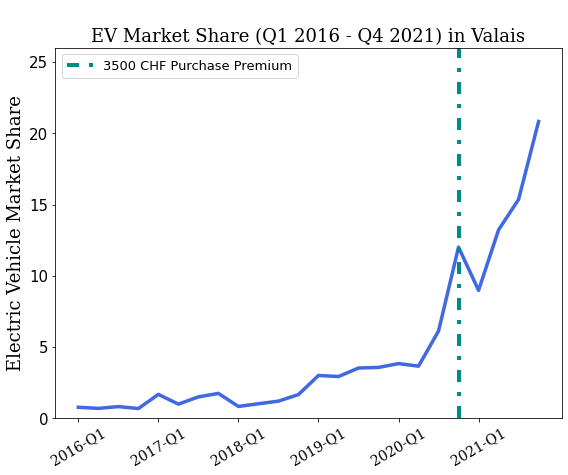

In [2848]:
def plotCantonEVRatio(canton):
    fonttype = 'serif'
    fig, ax = plt.subplots(figsize = (8, 6.7))
    evRatio = "EVRatio_" + canton
    theEV = ax.plot(YQRegistrations.YearQuarter, YQRegistrations[evRatio], color = 'royalblue', label = "All Vehicles", linewidth = 3.5)
    #ax.legend(loc = 'lower left')
    cantonName = CPDY[CPDY['Abbr'] == canton]['GermanCantonName'].iloc[0]
    
    CHF4000 = 'darkslategrey' 
    CHF3500 = 'darkcyan'
    CHF2000 ='lightseagreen'
    
    CHF4000LS = (0, (3, 1, 1, 1))
    CHF3500LS = (0, (3, 2.5, 1, 2.5))
    CHF2000LS = (0, (3, 4.5, 1, 4.5))
    
    if canton == 'TG':
        one = plt.axvline(x = 12, color = CHF4000, linestyle=CHF4000LS, label = '4000 CHF Purchase Premium', linewidth = 3)               
        two = plt.axvline(x = 16, color = CHF3500, linestyle=CHF3500LS, label = '3500 CHF Purchase Premium', linewidth = 3)
        three = plt.axvline(x = 20, color = CHF2000, linestyle=CHF2000LS, label = '2000 CHF Purchase Premium', linewidth = 4)
        
        ax.legend(handles = [one, two, three], fontsize = 12.99)
        
        
    if canton == 'SH':
        one = plt.axvline(x = 20, color = CHF2000, linestyle=CHF2000LS, label = '2000 CHF Purchase Premium', linewidth = 4)  
        plt.legend(handles = [one], fontsize = 12.99)
        
    if canton == 'TI':
        one = plt.axvline(x = 14, color = CHF2000, linestyle=CHF2000LS, label = '2000 CHF Purchase Premium', linewidth = 4) 
        plt.legend(handles = [one], fontsize = 12.99)
        
    if canton == 'VS':
        cantonName = 'Valais'
        one = plt.axvline(x = 19, color = CHF3500, linestyle=CHF3500LS, label = '3500 CHF Purchase Premium', linewidth = 4) 
        plt.legend(handles = [one], fontsize = 12.99)

    if canton == 'BE':
        cantonName = "Bern"
    
    ax.xaxis.set_ticks(np.arange(0, 24, 4))
    ax.xaxis.set_ticklabels(["2016-Q1","2017-Q1", "2018-Q1","2019-Q1", "2020-Q1", "2021-Q1"], rotation = 30, fontsize = 14,fontname = fonttype)
    #plt.xlabel("Year-Quarter", fontsize = 14)
    plt.ylabel("Electric Vehicle Market Share", fontsize = 18,fontname = fonttype)
    plt.title(f"\nEV Market Share (Q1 2016 - Q4 2021) in {cantonName}", fontsize = 18,fontname = fonttype)
    plt.yticks(np.arange(0, 30, 5), fontsize = 15)
    plt.ylim(top = 26)
    plt.ylim(bottom = 0)
    plt.tight_layout()
    
    plt.savefig("photos/" + evRatio + ".png")

for c in ['SZ','ZH','TG','TI', 'SH', 'VS']:
    plotCantonEVRatio(c)

In [30]:
### plot EVs Registered ###

    EVs_TI YearQuarter
0       34      2016-1
1       29      2016-2
2       29      2016-3
3       33      2016-4
4       31      2017-1
5       42      2017-2
6       32      2017-3
7       54      2017-4
8       43      2018-1
9       41      2018-2
10      37      2018-3
11      55      2018-4
12      90      2019-1
13      89      2019-2
14     133      2019-3
15     187      2019-4
16     139      2020-1
17     112      2020-2
18     234      2020-3
19     375      2020-4
20     179      2021-1
21     400      2021-2
22     395      2021-3
23     510      2021-4


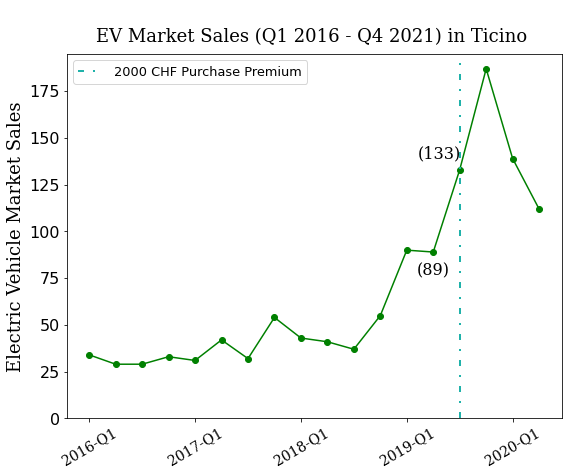

In [4492]:
def plotEVs(canton):
    fonttype = 'serif'
    fig, ax = plt.subplots(figsize = (8, 6.7))
    vehicles = "EVs_" + canton
    print(YQRegistrations[["EVs_TI", "YearQuarter"]])
    theEV = ax.plot(YQRegistrations.YearQuarter[:18], YQRegistrations[vehicles][:18], '-o', color = 'g', label = "All Vehicles")
    #ax.legend(loc = 'lower left')
    cantonName = CPDY[CPDY['Abbr'] == canton]['GermanCantonName'].iloc[0]
    
    
    n =  YQRegistrations[vehicles][:18].round(2)
    for i, txt in enumerate(n):
        txt = f"(" + str(txt) + ")"
        if i in [14]:
        #above
            ax.annotate(txt,(YQRegistrations.YearQuarter[i], YQRegistrations[vehicles][i]), textcoords="offset points", # how to position the text
                xytext=(-20,25), # distance from text to points (x,y)
                ha='center', va='top', size=16,color="k", fontname = 'serif')    
        #below
        if i in [13]:    
            ax.annotate(txt,(YQRegistrations.YearQuarter[i], YQRegistrations[vehicles][i]), textcoords="offset points", # how to position the text
                xytext=(0,-10), # distance from text to points (x,y)
                ha='center', va='top', size=16,color="k", fontname = 'serif')
    
    CHF4000 = 'darkslategrey' 
    CHF3500 = 'darkcyan'
    CHF2000 ='lightseagreen'
    
    CHF4000LS = (0, (3, 1, 1, 1))
    CHF3500LS = (0, (3, 2.5, 1, 2.5))
    CHF2000LS = (0, (3, 4.5, 1, 4.5))
    
    if canton == 'TG':
        one = plt.axvline(x = 12, color = CHF4000, linestyle=CHF4000LS, label = '4000 CHF Purchase Premium', linewidth = 2)               
        two = plt.axvline(x = 16, color = CHF3500, linestyle=CHF3500LS, label = '3500 CHF Purchase Premium', linewidth = 2)
        three = plt.axvline(x = 20, color = CHF2000, linestyle=CHF2000LS, label = '2000 CHF Purchase Premium', linewidth = 2)
        
        ax.legend(handles = [one, two, three], fontsize = 12.9)
        
    if canton == 'SH':
        one = plt.axvline(x = 20, color = CHF2000, linestyle=CHF2000LS, label = '2000 CHF Purchase Premium', linewidth = 2)  
        plt.legend(handles = [one], fontsize = 12.9)
        
    if canton == 'TI':
        one = plt.axvline(x = 14, color = CHF2000, linestyle=CHF2000LS, label = '2000 CHF Purchase Premium', linewidth = 2) 
        plt.legend(handles = [one], fontsize = 12.9)
        
    if canton == 'VS':
        cantonName = 'Valais'
        one = plt.axvline(x = 19, color = CHF3500, linestyle=CHF3500LS, label = '3500 CHF Purchase Premium', linewidth = 2) 
        plt.legend(handles = [one], fontsize = 12.9)

    if canton == 'BE':
        cantonName = "Bern"
    
    ax.xaxis.set_ticks(np.arange(0, 20, 4))
    ax.xaxis.set_ticklabels(["2016-Q1","2017-Q1", "2018-Q1","2019-Q1", "2020-Q1"], rotation = 30, fontsize = 14, fontname = fonttype)
    
    #plt.xlabel("Year-Quarter", fontsize = 18)
    plt.ylabel("Electric Vehicle Market Sales", fontsize = 18,fontname = fonttype)
    plt.title(f"\nEV Market Sales (Q1 2016 - Q4 2021) in {cantonName} \n", fontsize = 18, y=.96,fontname = fonttype)
    #plt.yticks(np.arange(0, 30, 5))
    plt.yticks( fontsize = 16)
    plt.ylim(auto = True)
    plt.ylim(bottom = 0)
    plt.tight_layout()
    
    plt.savefig("photos/" + vehicles + ".png")

for c in ['TI']:
    plotEVs(c)

In [4483]:
### plot all vehicles ###

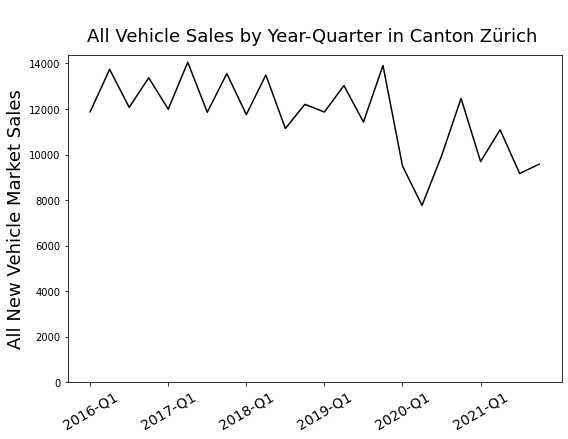

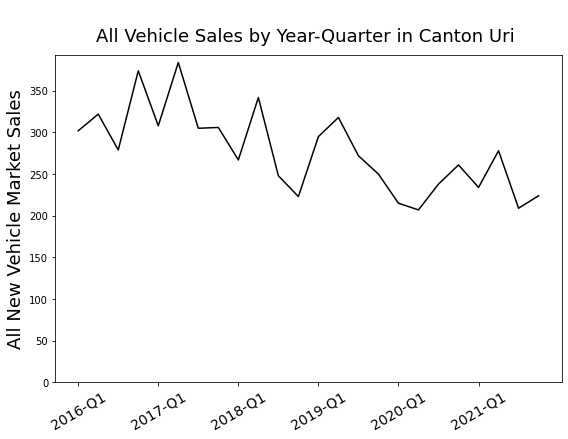

In [44]:
def plotAllVehicles(canton):
    fig, ax = plt.subplots(figsize = (8,6.2))
    vehicles = "AllVehicles_" + canton
    theEV = ax.plot(YQRegistrations.YearQuarter, YQRegistrations[vehicles], color = 'k', label = "All Vehicles")
    cantonName = CPDY[CPDY['Abbr'] == canton]['GermanCantonName'].iloc[0]
    
    CHF4000 = 'darkslategrey' 
    CHF3500 = 'darkcyan'
    CHF2000 ='lightseagreen'
    
    CHF4000LS = (0, (3, 1, 1, 1))
    CHF3500LS = (0, (3, 2.5, 1, 2.5))
    CHF2000LS = (0, (3, 4.5, 1, 4.5))
    
    if canton == 'TG':
        one = plt.axvline(x = 12, color = CHF4000, linestyle=CHF4000LS, label = '4000 CHF Purchase Premium', linewidth = 2)               
        two = plt.axvline(x = 16, color = CHF3500, linestyle=CHF3500LS, label = '3500 CHF Purchase Premium', linewidth = 2)
        three = plt.axvline(x = 20, color = CHF2000, linestyle=CHF2000LS, label = '2000 CHF Purchase Premium', linewidth = 2) 
        ax.legend(handles = [one, two, three], fontsize = 12.9)
        
    if canton == 'SH':
        one = plt.axvline(x = 20, color = CHF2000, linestyle=CHF2000LS, label = '2000 CHF Purchase Premium', linewidth = 2)  
        plt.legend(handles = [one], fontsize = 12.9)
        
    if canton == 'TI':
        one = plt.axvline(x = 14, color = CHF2000, linestyle=CHF2000LS, label = '2000 CHF Purchase Premium', linewidth = 2) 
        plt.legend(handles = [one], fontsize = 12.9)
        
    if canton == 'VS':
        cantonName = 'Valais'
        one = plt.axvline(x = 19, color = CHF3500, linestyle=CHF3500LS, label = '3500 CHF Purchase Premium', linewidth = 2) 
        plt.legend(handles = [one], fontsize = 12.9)

    if canton == 'BE':
        cantonName = "Bern"
    
    ax.xaxis.set_ticks(np.arange(0, 24, 4))
    ax.xaxis.set_ticklabels(["2016-Q1","2017-Q1", "2018-Q1","2019-Q1", "2020-Q1", "2021-Q1"], rotation = 30, fontsize = 14)
    
    plt.ylabel("All New Vehicle Market Sales", fontsize = 18)
    plt.title(f"\nAll Vehicle Sales by Year-Quarter in Canton {cantonName} \n", fontsize = 18, y=.96)
    plt.ylim(auto = True)
    plt.ylim(bottom = 0)
    plt.tight_layout()  
    plt.savefig("photos/" + vehicles + ".png")

for c in ['ZH','UR']:
    plotAllVehicles(c)

In [4202]:
def axisAnnotation(ax, seriesToPlot, canton_abbr, EVsExpectation, percentages, regressand):
    if (regressand == 'MkShr(100)_log'):
        
        n =  EVsExpectation[EVsExpectation['Canton_' + canton_abbr] == 1.0]['EVRatio'].round(2)
        #print(seriesToPlot['RealMinusExpected'])
        if(canton_abbr == 'SH'):
                for i, txt in enumerate(n):
                    txt = f"(" + str(txt) + ")"
                    if i in [0,2,4,7,9,12,15,21]:
                    #above
                        ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]), textcoords="offset points", # how to position the text
                            xytext=(-5,25), # distance from text to points (x,y)
                            ha='center', va='top', size=16,color="k", fontname = 'serif')    
                    #below
                    if i in [1,3,5,8,10,14,16,19,23]:    
                        ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]), textcoords="offset points", # how to position the text
                            xytext=(0,-12), # distance from text to points (x,y)
                            ha='center', va='top', size=16,color="k", fontname = 'serif')
                    
        if(canton_abbr == 'TG'):
            for i, txt in enumerate(n):
                
                txt = "(" + str(txt) + ")"
                
                #below
                if i in [0,2,7,9, 17]:
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]), textcoords="offset points", # how to position the text
                         xytext=(0,-24.5), # distance from text to points (x,y)
                         ha='center', size=16,color="k")
                
                #less below
                elif i in [13]:
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]), textcoords="offset points", # how to position the text
                         xytext=(0,-18.5), # distance from text to points (x,y)
                         ha='center', size=16,color="k")
                    
                #above
                elif i in [1,4,6,14,19,21, 23]:
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]), textcoords="offset points", # how to position the text
                         xytext=(0,15), # distance from text to points (x,y)
                         ha='center', size=16,color="k")
                    
                #above, left
                elif i in [11]: 
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]), textcoords="offset points", # how to position the text
                         xytext=(-10,10), # distance from text to points (x,y)
                         ha='right', size=16,color="k")
                
                #above, right
                elif i in [12]: 
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]), textcoords="offset points", # how to position the text
                         xytext=(52,12), # distance from text to points (x,y)
                         ha='right', size=16,color="k")
                    
        if(canton_abbr == 'TI'):
            for i, txt in enumerate(n):
                
                txt = "(" + str(txt) + ")"
                
                if i in [0,2,5,7,12,16,19,21,23]:
                    #above
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]), textcoords="offset points", # how to position the text
                        xytext=(-5,25), # distance from text to points (x,y)
                        ha='center', va='top', size=16,color="k", fontname = 'serif') 
                    
                if i in [14]:
                    #above left
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]), textcoords="offset points", # how to position the text
                        xytext=(-40,25), # distance from text to points (x,y)
                        ha='center', va='top', size=16,color="k", fontname = 'serif')   
                    #below
                if i in [6,9,13,17,20]:    
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]), textcoords="offset points", # how to position the text
                        xytext=(0,-12), # distance from text to points (x,y)
                        ha='center', va='top', size=16,color="k", fontname = 'serif')
                    
        if(canton_abbr == 'VS'):
            for i, txt in enumerate(n):
                
                txt = "(" + str(txt) + ")"
                
                if i in [0,2,4,7,12,14,16,23]:
                    #above
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]), textcoords="offset points", # how to position the text
                        xytext=(-5,25), # distance from text to points (x,y)
                        ha='center', va='top', size=16,color="k", fontname = 'serif') 
                    
                if i in [19]:
                    #above right
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]), textcoords="offset points", # how to position the text
                        xytext=(35,20), # distance from text to points (x,y)
                        ha='center', va='top', size=16,color="k", fontname = 'serif')
                    
                #below
                if i in [1,3,5,8,13,17,20]:    
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]), textcoords="offset points", # how to position the text
                        xytext=(0,-12), # distance from text to points (x,y)
                        ha='center', va='top', size=16,color="k", fontname = 'serif')
    
    
    elif (regressand == 'EVRatio'):
        n =  EVsExpectation[EVsExpectation['Canton_' + canton_abbr] == 1.0]['EVRatio'].round(2)
        percent = ""
        ####################################
        if percentages == True:
            num = seriesToPlot['RealMinusExpected']
            denom = EVsExpectation[EVsExpectation['Canton_' + canton_abbr] == 1.0]['EVRatio'].to_frame().reset_index()['EVRatio']
            print(num)
            print(denom)

            percent = "%"    
                #print(seriesToPlot['RealMinusExpected'][i])
                #print(EVsExpectation[EVsExpectation['Canton_' + canton_abbr] == 1.0]['EVRatio'][i + 528])
            n = (num * 100 / denom).round(2)

            #print(num)
            #print(denom)
            #print(n)
            #n =  (seriesToPlot['RealMinusExpected'][i]) / (EVsExpectation[EVsExpectation['Canton_' + canton_abbr] == 1.0]['EVRatio'][i])
            #n = n.round(2) * 100
            print()
            print()
        #####################################

        if(canton_abbr == 'TG'):
            for i, txt in enumerate(n):
                txt = f"({percent}" + str(txt) + ")"
                if (i%3==2) and i != 2 and i != 20 and i != 17 and i != 14 and i != 11:
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]+.40), textcoords="offset points", # how to position the text
                         xytext=(3,-9), # distance from text to points (x,y)
                         ha='center', size=16,color="k")
                #below
                elif i==20 or i == 17 or i == 15 or i == 13:
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]+.40), textcoords="offset points", # how to position the text
                         xytext=(-5,-50), # distance from text to points (x,y)
                         ha='center', size=16,color="k")
                #above
                elif i == 14 or i == 19 or i == 21 or i==1 or i == 3:
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]+.40), textcoords="offset points", # how to position the text
                         xytext=(-5,-15), # distance from text to points (x,y)
                         ha='center', size=16,color="k")
                #above, left
                elif i == 12 or i ==11: 
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]+.40), textcoords="offset points", # how to position the text
                         xytext=(-4,-15), # distance from text to points (x,y)
                         ha='right', size=16,color="k")

        elif(canton_abbr == 'TI'):
            for i, txt in enumerate(n):
                txt = f"({percent}" + str(txt) + ")"
                #above
                if i == 19 or i==1 or i == 7:
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]+.40), textcoords="offset points", # how to position the text
                         xytext=(0,-45), # distance from text to points (x,y)
                         ha='center', va='top', size=16,color="k")
                #more above
                elif i == 21:
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]+.40), textcoords="offset points", # how to position the text
                         xytext=(-5,0), # distance from text to points (x,y)
                         ha='center', va='top', size=16,color="k")

                #above left
                elif i == 14:
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]+.40), textcoords="offset points", # how to position the text
                         xytext=(-25,-4), # distance from text to points (x,y)
                         ha='center', va='top', size=16,color="k")

                #above right
                elif i == 17:
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]+.40), textcoords="offset points", # how to position the text
                         xytext=(20,-4), # distance from text to points (x,y)
                         ha='center', va='top', size=16,color="k")

                #below
                elif i==5 or i == 8 or i == 10 or i == 16 or i == 24:
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]+.40), textcoords="offset points", # how to position the text
                         xytext=(-5,-15), # distance from text to points (x,y)
                         ha='center', size=16,color="k")

                #more below
                elif i == 12 or i == 23 or i == 3:
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]+.20), textcoords="offset points", # how to position the text
                         xytext=(-5,-35), # distance from text to points (x,y)
                         ha='center', size=16,color="k")

        elif(canton_abbr == 'VS'):
            for i, txt in enumerate(n):
                txt = f"({percent}" + str(txt) + ")"
                #below
                if i==1 or i==4:
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]+.40), textcoords="offset points", # how to position the text
                         xytext=(-5,-6), # distance from text to points (x,y)
                         ha='center', va='top', size=16,color="k")
                #more above
                elif i == 21 or i == 23:
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]+.40), textcoords="offset points", # how to position the text
                         xytext=(-5,0), # distance from text to points (x,y)
                         ha='center', va='top', size=16,color="k")

                #top left
                elif i == 19:
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]+.40), textcoords="offset points", # how to position the text
                         xytext=(-37,-2), # distance from text to points (x,y)
                         ha='center', va='top', size=16,color="k")

                #below
                elif i == 10:
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]+.40), textcoords="offset points", # how to position the text
                         xytext=(-5,-15), # distance from text to points (x,y)
                         ha='center', size=16,color="k")

                #more below
                elif i == 12 or i == 8 or i == 3 or i == 16 or i == 18 or i == 20 or i == 22:
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]+.20), textcoords="offset points", # how to position the text
                         xytext=(0,-35), # distance from text to points (x,y)
                         ha='center', size=16,color="k")

        elif(canton_abbr == 'SH'):
            for i, txt in enumerate(n):
                txt = f"({percent}" + str(txt) + ")"
                #above
                if i==2 or i == 15:
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]+.40), textcoords="offset points", # how to position the text
                         xytext=(0,-5), # distance from text to points (x,y)
                         ha='center', va='top', size=16,color="k")
                #more above
                elif i == 24:
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]+.40), textcoords="offset points", # how to position the text
                         xytext=(-5,0), # distance from text to points (x,y)
                         ha='center', va='top', size=16,color="k")

                #top right
                elif i in [12,7,22,11,21]:
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]+.40), textcoords="offset points", # how to position the text
                         xytext=(7,-10), # distance from text to points (x,y)
                          va='top', size=16,color="k")

                #top left
                elif i in [20]:
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]+.40), textcoords="offset points", # how to position the text
                         xytext=(-60,-10), # distance from text to points (x,y)
                          va='top', size=16,color="k")

                #below
                elif i in [24]:
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]+.40), textcoords="offset points", # how to position the text
                         xytext=(-5,-15), # distance from text to points (x,y)
                         ha='center', size=16,color="k")

                #more below
                elif i in [19,16,14,23,10, 8,4]:
                    ax.annotate(txt,(seriesToPlot.YearQuarter[i], seriesToPlot['RealMinusExpected'][i]+.20), textcoords="offset points", # how to position the text
                         xytext=(0,-35), # distance from text to points (x,y)
                         ha='center', size=16,color="k")

            ###########################

        

In [4499]:
def plotDifference(model, cantonName, title, modelnumber, annotation = False, regressand = "EVRatio", pointer = False):
    #graph set-up
    fig, ax = plt.subplots(figsize = (16, 9))
    plt.ylim(bottom = -8, top = 24) #-8, 24
    plt.ylim(bottom = -1.49, top = 2.2) #small
    plt.yticks(fontsize = 20)
    ax.xaxis.set_ticks(np.arange(0, 24, 4))
    ax.xaxis.set_ticklabels(["   2016","   2017", "   2018","   2019", "   2020", "   2021"], rotation = 0, fontsize = 20)
    plt.grid(axis="y") 
    
    #classifies canton name
    canton_abbr = cantonName
    cantonName = CPDY[CPDY['Abbr'] == cantonName]['GermanCantonName'].iloc[0]
    
    #adjustable parameters
    titleSize = 29
    legendTxtSize = 20
    policyLineWidth = 4
    graphLineWidth = 4
    
    
    if canton_abbr in ['TG','SH','TI','VS']:
        
        #adjustable types of dotted lines and color of lines representing policy implimentation
        CHF4000LS = (0, (3, 1, 1, 1))
        CHF4000C = 'darkslategrey' 
        CHF3500LS = (0, (3, 2.5, 1, 2.5))
        CHF3500C = 'darkcyan'
        CHF2000LS = (0, (3, 4.5, 1, 4.5))
        CHF2000C ='lightseagreen'
        
        if canton_abbr == 'TG':
            one = plt.axvline(x = 12, color = CHF4000C, linestyle=CHF4000LS, label = '4000 CHF Purchase Premium', linewidth = policyLineWidth)               
            two = plt.axvline(x = 16, color = CHF3500C, linestyle=CHF3500LS, label = '3500 CHF Purchase Premium', linewidth = policyLineWidth)
            thr = plt.axvline(x = 20, color = CHF2000C, linestyle=CHF2000LS, label = '2000 CHF Purchase Premium', linewidth = policyLineWidth)
            legend1 = plt.legend(handles = [one, two, thr], fontsize = legendTxtSize, loc = 'upper left')

        if canton_abbr == 'SH':
            one = plt.axvline(x = 20, color = CHF2000C, linestyle=CHF2000LS, label = '2000 CHF Purchase Premium', linewidth = policyLineWidth)  
            legend1 = plt.legend(handles = [one], fontsize = legendTxtSize, loc = 'upper left')

        if canton_abbr == 'TI':
            one = plt.axvline(x = 14, color = CHF2000C, linestyle=CHF2000LS, label = '2000 CHF Purchase Premium', linewidth = policyLineWidth)
            
            if(pointer == False): 
                legend1 = plt.legend(handles = [one], fontsize = legendTxtSize, loc = 'upper left')

        if canton_abbr == 'VS':
            cantonName = 'Valais'
            one = plt.axvline(x = 19, color = CHF3500C, linestyle=CHF3500LS, label = '3500 CHF Purchase Premium', linewidth = policyLineWidth) 
            if(pointer == False): 
                legend1 = plt.legend(handles = [one], fontsize = legendTxtSize, loc = 'upper left')
    
    ## Model type 0 (without controls) ##
    if (modelnumber == 0):
        plt.ylim(bottom = -0.9, top = 3.75) #small  #-2.98 keeps even ratio #4.4
        EVsExpectation = CYQ_dummies
        seriesToPlot = EVsExpectation[EVsExpectation['Canton_' + canton_abbr] == 1.0]['MkShr(100)_log'].to_frame().reset_index()
        seriesToPlot['YearQuarter'] = YQRegistrations['YearQuarter']
        
        theEV = ax.plot(YQRegistrations.YearQuarter, seriesToPlot['MkShr(100)_log'], '-o', color = 'royalblue', label = "Electric Vehicles", linewidth = graphLineWidth)
        
        #theEV = ax.plot(YQRegistrations.YearQuarter, YQRegistrations[regressand + "_" + canton_abbr], color = 'royalblue', label = "Electric Vehicles", linewidth = graphLineWidth)
        
        
        
        plt.ylabel("\n          $\it{ln}$(EV Market Share)", fontsize = 20,fontname = 'serif',horizontalalignment='right',y=0.75)
        
        if (regressand == 'EVRatio'):
            plt.ylabel("\n EV Market Share (Uncontrolled)", fontsize = 28,fontname = 'serif')
        ############
        text = ax.text(5.12,3.9,"(no controls)", size=18, verticalalignment='center', fontname = 'serif')
        
        titlestring = "\n $\it{ln}$(EV Market Share) in" + f" {cantonName}. Model: (2.1) \n  "
        plt.title(titlestring, fontsize = titleSize,fontname = 'serif')
        
        
        if(annotation == True):
            ax.text(-0.35,-0.75,"(Numbers in Parentheses Represent Actual Market Share)", size=15, verticalalignment='bottom', fontname = 'serif')
            seriesToPlot['RealMinusExpected'] = seriesToPlot['MkShr(100)_log']
            axisAnnotation(ax, seriesToPlot, canton_abbr,EVsExpectation, False, regressand)
        plt.tight_layout()
        ##plt.savefig("ModelGifs/" + canton_abbr + "/img" + canton_abbr + str(modelnumber) + ".png")
   
    
    ## Model type 1+ (with controls) ##
    else:
        
        EVsExpectation = CYQ_dummies
        EVsExpectation['RealMinusExpected'] = CYQ_dummies[regressand].dropna() - model.predict()
        
        seriesToPlot = EVsExpectation[EVsExpectation['Canton_' + canton_abbr] == 1.0]['RealMinusExpected'].to_frame().reset_index()
        seriesToPlot['YearQuarter'] = YQRegistrations['YearQuarter']
        
        theEV = ax.plot(seriesToPlot.YearQuarter, seriesToPlot['RealMinusExpected'], '-o', markersize = 8, color = 'royalblue', label = "Year-Controlled EV Market Share", linewidth = graphLineWidth)
        
        
        if modelnumber == 6:
            print(seriesToPlot[['YearQuarter','RealMinusExpected']])
        plt.ylabel("\n Residuals $\it{ln}$(EV Market Share)", fontsize = 20, fontname = 'serif',horizontalalignment='right',y=0.75)
        ######
        text = ax.text(3.68,2.32,f"{title}", size=20.5, verticalalignment='center',fontname = 'serif') #3.68
        ######
        
        titlestring = f"\n EV Market Share in {cantonName}. Model: (2.{modelnumber}) \n  "
        plt.title(titlestring, fontsize = titleSize, fontname = 'serif')
        
        if (modelnumber in [1,2,3,4,5,6,7]):
            plt.fill_between(seriesToPlot.YearQuarter,seriesToPlot['RealMinusExpected'], 0,where = (seriesToPlot['RealMinusExpected'] >= 0), color = 'lightgreen', alpha = 0.6, interpolate = True )
            plt.fill_between(seriesToPlot.YearQuarter,seriesToPlot['RealMinusExpected'], 0,where = (seriesToPlot['RealMinusExpected'] < 0), color = 'lightcoral',alpha = 0.6, interpolate = True )
        
        
            legend_elements = [Patch(facecolor='lightgreen', alpha = 0.6, edgecolor='k',label='Under Predicted'),
                           Patch(facecolor='lightcoral', alpha = 0.6, edgecolor='k',label='Over Predicted')]
            plt.legend(handles=legend_elements, loc='lower right', fontsize = 12 + 1.2)
            #if legend1 is not None:
            #    plt.gca().add_artist(legend1)
            ax.text(20.8,-1.125,"Residuals Are:", size=15, verticalalignment='bottom', fontname = 'serif')
        
        if(annotation == True):
            if(pointer == False):
            ######
                #ax.text(-0.35,-0.95,"(Numbers in Parentheses Represent Uncontrolled Market Share)", size=15, verticalalignment='bottom')
                if modelnumber != 0:
                    axisAnnotation(ax, seriesToPlot, canton_abbr,EVsExpectation, False, regressand)
            ######
        if modelnumber == 6:
            print("here")
            Drawing_uncolored_circle = Ellipse( (21, 0 ),
                                      5,0.66 ,fill = False, edgecolor = 'red' )
            ax.add_artist( Drawing_uncolored_circle )
            
        plt.tight_layout()
    
    #if(modelnumber in [1]):
    #    plt.fill_between(seriesToPlot.YearQuarter,seriesToPlot['RealMinusExpected'], 0,where = (seriesToPlot['RealMinusExpected'] >= 0), color = 'lightgreen', alpha = 0.5, interpolate = True )
    #    plt.fill_between(seriesToPlot.YearQuarter,seriesToPlot['RealMinusExpected'], 0,where = (seriesToPlot['RealMinusExpected'] < 0), color = 'lightcoral',alpha = 0.5, interpolate = True )
    
    if(pointer == True):  
        ax.annotate('3500 CHF Purchase Premium', (seriesToPlot.YearQuarter[19], 1.79),
            xytext=(0.59,0.878),size = 29, textcoords='axes fraction',
            arrowprops=dict(facecolor=CHF3500C, shrink=0.1, edgecolor=CHF3500C, lw=4),
            horizontalalignment='right', verticalalignment='center', bbox=dict(boxstyle="Round", fc="cyan", ec="b", lw=2, alpha = 0.2),fontname = 'serif')
        
    plt.savefig("ModelGifs/" + canton_abbr + "/img" + canton_abbr + str(modelnumber) + ".png")
    %matplotlib inline

In [4500]:
### creates graph for analysis ###
def stage123456(cantonName):
    
    regressand = 'MkShr(100)_log'
    #plotCantonEVRatio_noControls(cantonName)
    plotDifference("",cantonName,"",0, False, regressand, False)
    
    newModel = []
    X_JY = CYQ_dummies[newModel]
    newmodel = sm.OLS(CYQ_dummies[[regressand]], sm.add_constant(X_JY), missing = 'drop').fit()
    plotDifference(newmodel, cantonName, "(controlled by a constant)",1, False, regressand, True)
    
    newModel = priceControls
    X_JY = CYQ_dummies[newModel]
    newmodel = sm.OLS(CYQ_dummies[[regressand]], sm.add_constant(X_JY), missing = 'drop').fit()
    plotDifference(newmodel, cantonName, "(controlled by a constant, vehicle price)",2, False, regressand, True)
    
    newModel = priceControls + socialControls
    X_JY = CYQ_dummies[newModel]
    newmodel = sm.OLS(CYQ_dummies[[regressand]], sm.add_constant(X_JY), missing = 'drop').fit()
    plotDifference(newmodel, cantonName,"(controlled by a constant, vehicle price, social)",3, False, regressand, True)
    
    newModel = priceControls + socialControls + cantonControls
    X_JY = CYQ_dummies[newModel]
    newmodel = sm.OLS(CYQ_dummies[[regressand]], sm.add_constant(X_JY), missing = 'drop').fit()
    plotDifference(newmodel, cantonName, "(controlled by a constant, vehicle price, social, canton)",4, False, regressand, True)
    
    newModel = priceControls + socialControls  + cantonControls + yearControls
    X_JY = CYQ_dummies[newModel]
    newmodel = sm.OLS(CYQ_dummies[[regressand]], sm.add_constant(X_JY), missing = 'drop').fit()
    plotDifference(newmodel, cantonName,"(controlled by a constant, vehicle price, social, canton, year)",6, False, regressand, True)
    
    newModel = priceControls + socialControls  + cantonControls + yearControls + ['PP_1000']
    X_JY = CYQ_dummies[newModel]
    newmodel = sm.OLS(CYQ_dummies[[regressand]], sm.add_constant(X_JY), missing = 'drop').fit()
    plotDifference(newmodel, cantonName,"(controlled by a constant, vehicle price, social, canton, year AND purchase premium)",7, True, regressand, False)

In [4501]:
### builds photos into a gif ###
def makeGifs(cantonName):
    kwargs_write = {'quantizer':'nq'}
    images = []
    filenames = []
    for i in [1,2,3,4,6,6,6]:
        filenames.append("ModelGifs/" + cantonName + '/img' + cantonName + str(i) + '.png')

    for filename in filenames:
        images.append(imageio.imread(filename))
    exportname = cantonName +'.gif'
    imageio.mimsave("ModelGifs/" + cantonName + '/' + exportname, images, duration = 3.9)

In [4502]:
### stages and creates the gif ###
def stageAndGifs(cantonName):
    stage123456(cantonName)
    makeGifs(cantonName)
#for cantonName in cantons_abbr:
for cantonName in ['TG']:#, 'TI', 'TG', 'VS']:#, 'SH', 'VS', 'TG']:#, 'TI', 'SH','TG']:#,'VS', 'TI','SH']:#, 'VS', 'TI', 'SH', 'UR', 'ZH']:, 
    stageAndGifs(cantonName)

   YearQuarter  RealMinusExpected
0       2016-1          -0.080248
1       2016-2           0.196266
2       2016-3          -0.517241
3       2016-4          -0.336056
4       2017-1          -0.278082
5       2017-2          -0.377347
6       2017-3          -0.208468
7       2017-4          -0.556640
8       2018-1          -0.277935
9       2018-2          -0.248842
10      2018-3           0.011961
11      2018-4           0.288089
12      2019-1           0.332715
13      2019-2           0.082484
14      2019-3           0.592009
15      2019-4           0.292096
16      2020-1           0.265036
17      2020-2           0.256413
18      2020-3           0.150275
19      2020-4           0.106918
20      2021-1           0.160104
21      2021-2           0.169576
22      2021-3           0.035641
23      2021-4          -0.058726
here


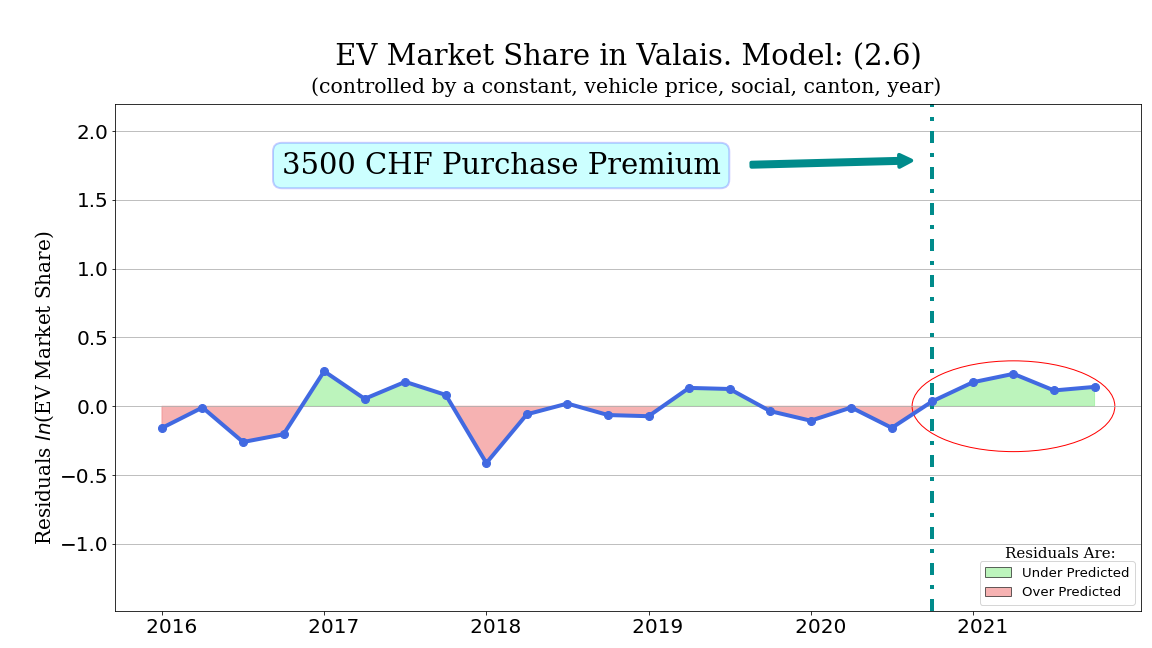

In [4474]:
abbr = 'VS'
Image(filename='ModelGifs/' + abbr + '/img' + abbr + '6.png')

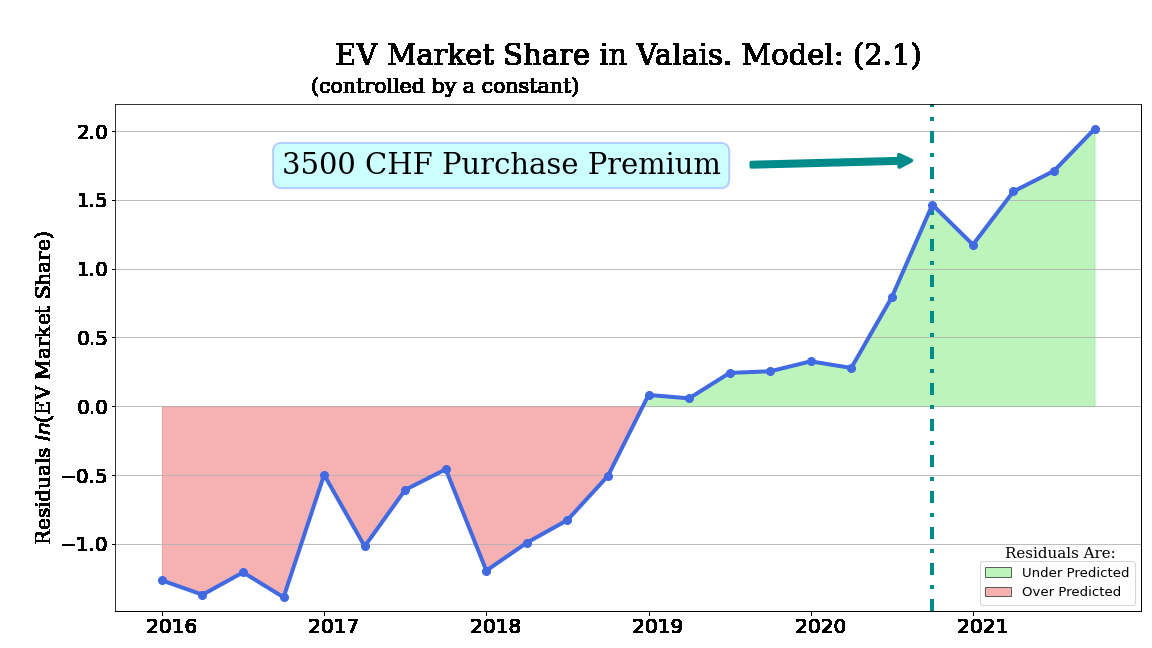

In [4459]:
abbr = 'VS'
Image(filename='ModelGifs/' + abbr + '/' + abbr + '.gif')

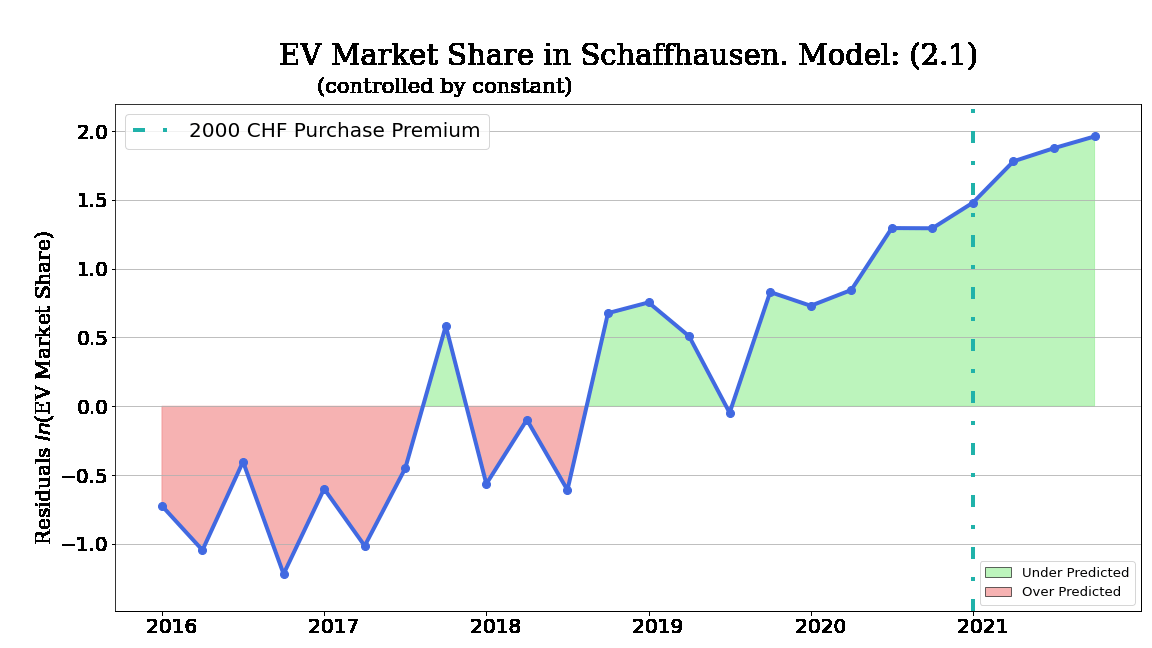

In [3963]:
Image(filename='ModelGifs/SH/SH.gif')

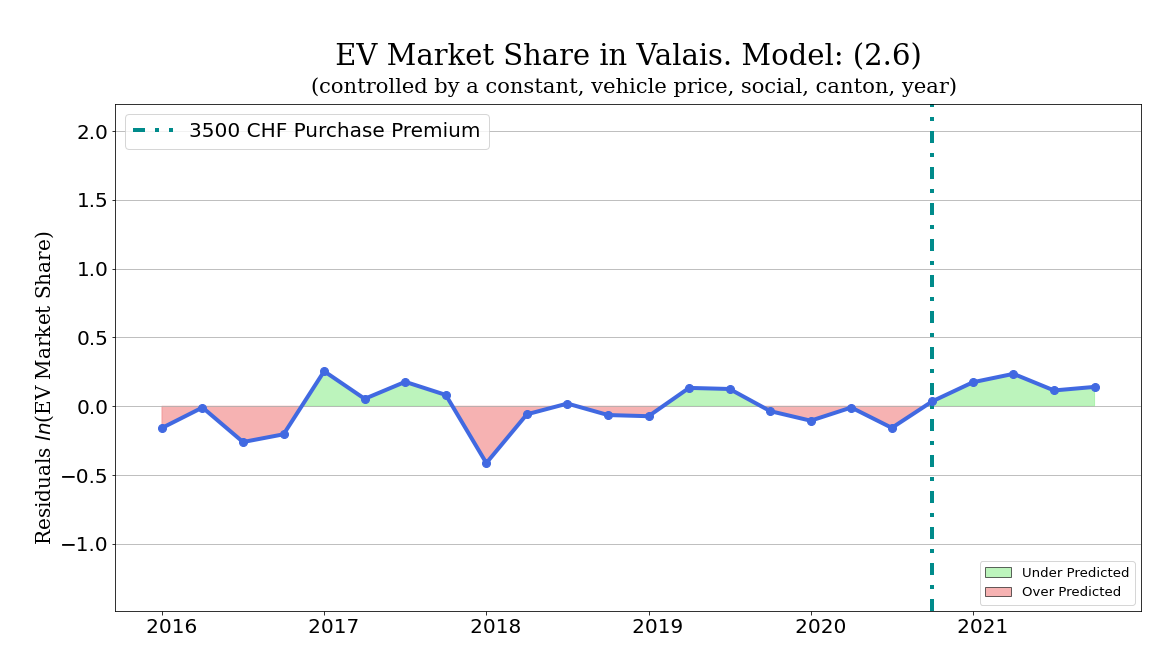

In [4234]:
Image(filename='ModelGifs/VS/imgVS6.png')

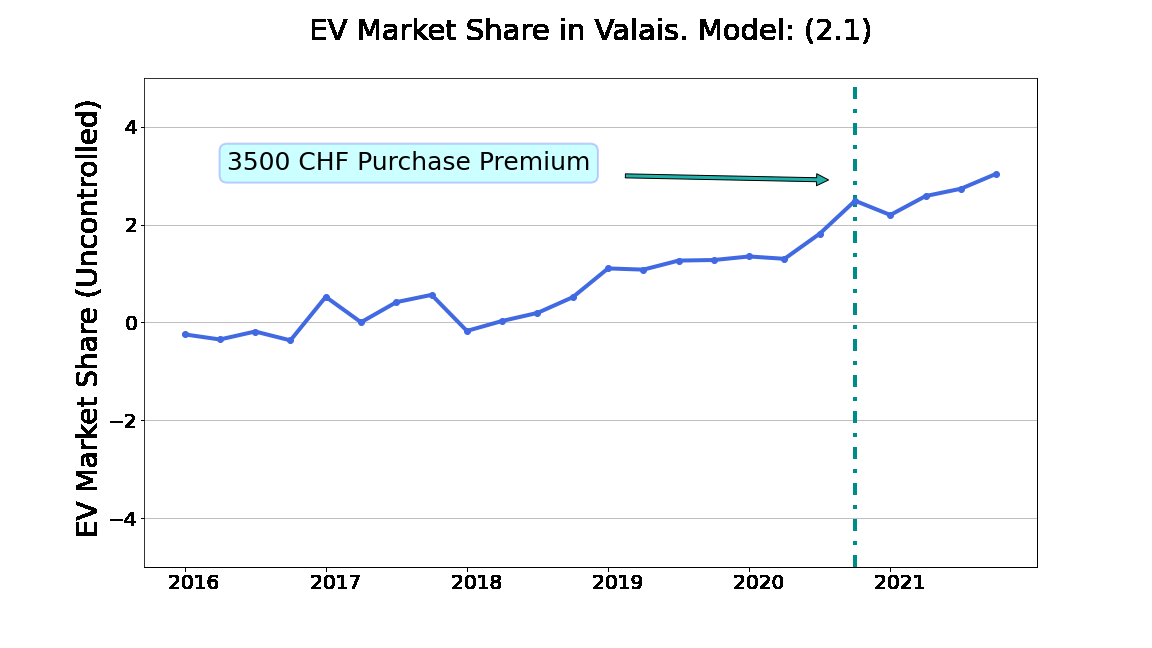

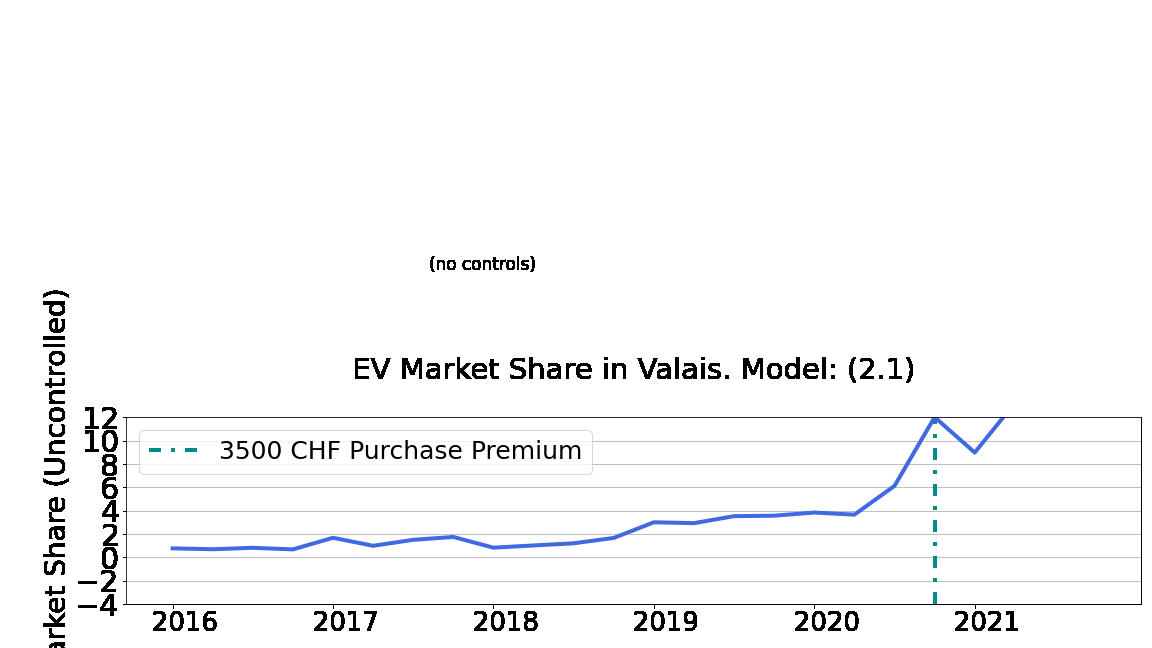

In [645]:
Image(filename='ModelGifs/VS/VS.gif')

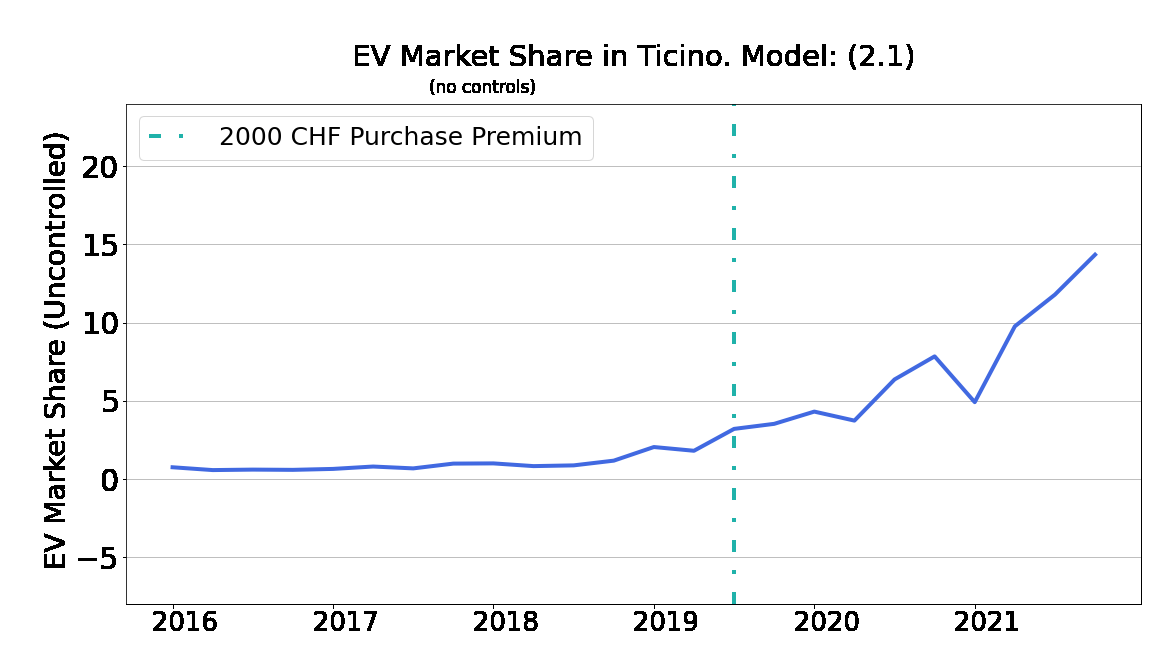

In [626]:
Image(filename='ModelGifs/TI/TI.gif')

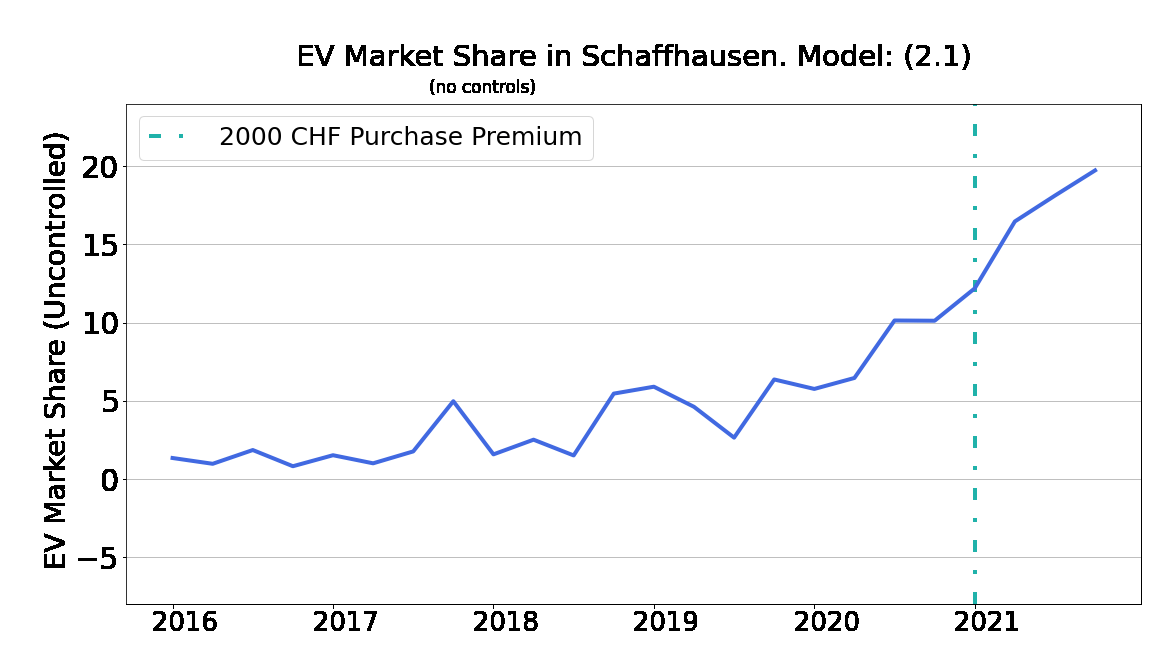

In [627]:
Image(filename='ModelGifs/SH/SH.gif')

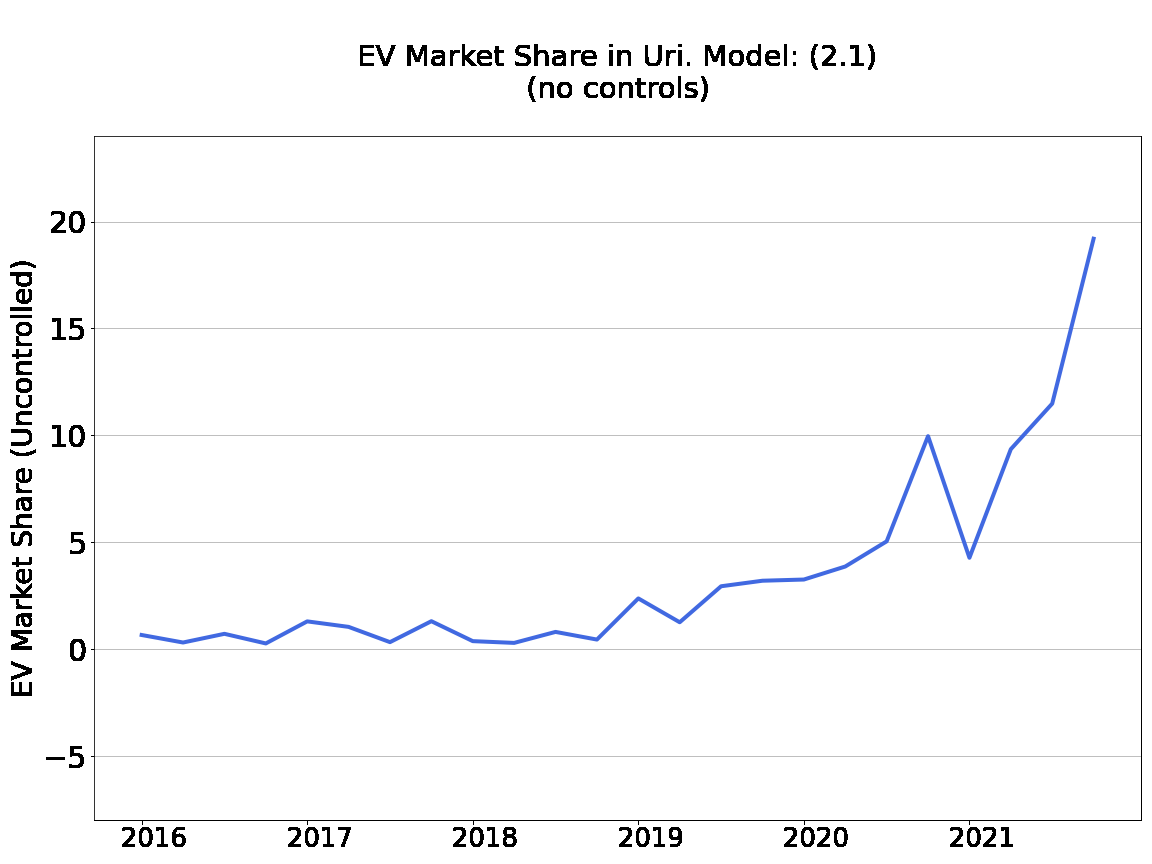

In [497]:
Image(filename='ModelGifs/UR/UR.gif')

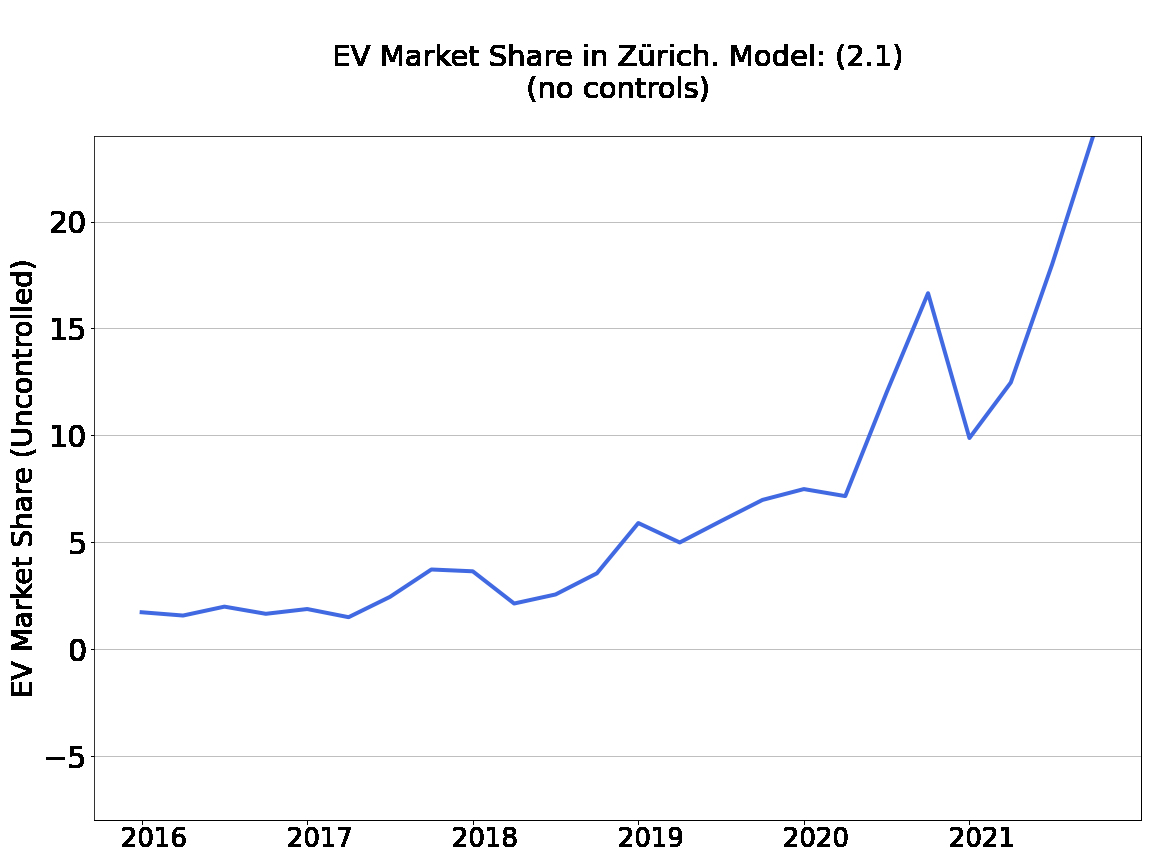

In [498]:
Image(filename='ModelGifs/ZH/ZH.gif')

In [4497]:
print(CPDY[CPDY['FrenchCantonName'] != "Geneva"].head(26))

   Abbr  Year Canton-Year    FrenchCantonName  Population_All  Area  \
0    ZH  2016     ZH-2016              Zurich         1458087  1729   
1    BE  2016     BE-2016               Berne         1005094  5959   
2    LU  2016     LU-2016             Lucerne          395448  1493   
3    UR  2016     UR-2016                 Uri           35377  1077   
4    SZ  2016     SZ-2016             Schwtyz          153215   908   
5    OW  2016     OW-2016              Obwald           36776   491   
6    NW  2016     NW-2016             Nidwald           41856   276   
7    GL  2016     GL-2016              Glaris           39385   685   
8    ZG  2016     ZG-2016                Zoug          121819   239   
9    FR  2016     FR-2016            Fribourg          305665  1671   
10   SO  2016     SO-2016             Soleure          265134   791   
11   BS  2016     BS-2016          Bâle-Ville          187917    37   
12   BL  2016     BL-2016       Bâle-Campagne          281404   518   
13   S